# Import Data

In [1]:
import pandas as pd

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.concat([pd.read_csv(f'../../../../data/F_feature_selection/feature_selection-{year}.csv', sep=';') for year in [2019, 2020, 2021, 2022]])
df_test = pd.read_csv('../../../../data/F_feature_selection/feature_selection-2023.csv', sep=';')

In [4]:
columns_to_drop = [
    'latitude', 'longitude',
    'pedestrian_location', 'pedestrian_action',
    'hour_sin', 'hour_cos', 'day_of_week_sin', 'day_of_week_cos', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'age',
    'direction_of_travel_other'
]

object_type = ['role', 'age_group', 'vehicle_category_simplified', 'vehicle_category_simplified_other', 'time_of_day']

na_with_meaning = [
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type',
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other', 'motor_type_other',
    'sex', 
    
    #'pedestrian_location', 'pedestrian_action'
]

columns_to_int32 = [
    'location', 'type_of_collision', 'reserved_lane_present', 'horizontal_alignment', 'infrastructure', 'accident_situation', 'position',
    'fixed_obstacle_struck', 'mobile_obstacle_struck', 'initial_point_of_impact', 'main_maneuver_before_accident', 'motor_type', 
    'fixed_obstacle_struck_other', 'mobile_obstacle_struck_other', 'initial_point_of_impact_other', 'main_maneuver_before_accident_other',
    'motor_type_other','vehicle_category_involved_bicycle', 'vehicle_category_involved_bus_coach', 'vehicle_category_involved_hgv_truck',
    'vehicle_category_involved_light_motor_vehicle', 'vehicle_category_involved_other', 'vehicle_category_involved_powered_2_3_wheeler',
    'used_belt', 'used_helmet', 'used_child_restraint', 'used_airbag', 'impact_score', 'impact_score_other', 'impact_delta', 'surface_quality_indicator',
    'lighting_ordinal', 'weather_ordinal', 'injury_target', 'sex', 'day_of_week', 'speed_limit'
]

In [5]:
for x in [df, df_test]:
    # Remove rows or columns with missing values that do not encode info.
    x.drop(columns=columns_to_drop, inplace=True)    
    x.replace(-1, pd.NA, inplace=True)
    x[na_with_meaning] = x[na_with_meaning].fillna(-1)
    x[['vehicle_category_simplified', 'vehicle_category_simplified_other']] = x[['vehicle_category_simplified', 'vehicle_category_simplified_other']].fillna('no vehicle')
    x.dropna(inplace=True)
    x[columns_to_int32] = x[columns_to_int32].astype('int32')
    
    # Drop rows with impossible speed limit
    # France has a maximum speed limit of 130
    x.drop(index=x[x['speed_limit'] > 130].index, inplace=True)
 

C:\Users\David\AppData\Local\Temp\ipykernel_18764\4081092471.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)
C:\Users\David\AppData\Local\Temp\ipykernel_18764\4081092471.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x[na_with_meaning] = x[na_with_meaning].fillna(-1)


In [ ]:
num_cols = ['speed_limit', 'day_of_week', 'impact_score', 'impact_score_other', 'impact_delta', 'road_complexity_index', 'surface_quality_indicator', 'lighting_ordinal', 'weather_ordinal', 'vehicle_category_involved_bicycle', 'vehicle_category_involved_bus_coach', 'vehicle_category_involved_hgv_truck','vehicle_category_involved_light_motor_vehicle', 'vehicle_category_involved_other', 'vehicle_category_involved_powered_2_3_wheeler']

cat_cols = df.columns.difference(num_cols + ['injury_target'])

In [7]:
X_train = df.drop(columns='injury_target')
y_train = df['injury_target']

X_test = df_test.drop(columns='injury_target')
y_test = df_test['injury_target']

# Models

In [8]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifierCV, LassoCV, RidgeCV
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score, RandomizedSearchCV, train_test_split

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler

#from mord import LogisticIT, LogisticAT

### Ridge Classifier

In [ ]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('undersample', RandomUnderSampler(sampling_strategy={0:68000, 1:68000, 2:68000})),
    ('classifier', RidgeClassifierCV(alphas=[0.1*x for x in range(1, 101)], scoring='f1_macro'))
])
pipeline.fit(X_train, y_train)

,steps,"[('transform', ...), ('undersample', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0       0.83      0.74      0.78     51051
           1       0.62      0.51      0.56     39476
           2       0.43      0.73      0.54     17440

    accuracy                           0.66    107967
   macro avg       0.63      0.66      0.63    107967
weighted avg       0.69      0.66      0.66    107967



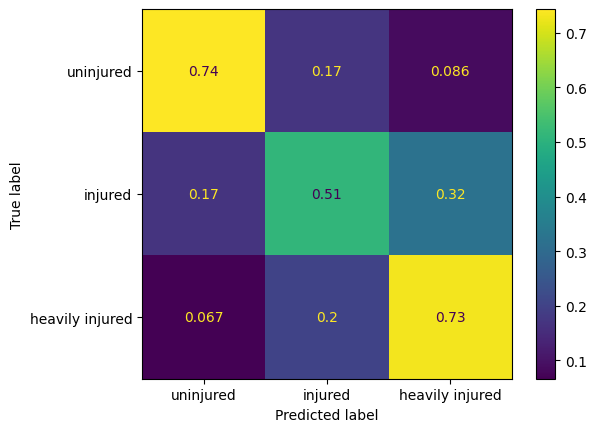

In [ ]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

### Random Forest

In [ ]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('classifier', BalancedRandomForestClassifier(n_jobs=-1, n_estimators=100, sampling_strategy='not minority', replacement=True, bootstrap=True))
])
pipeline.fit(X_train, y_train)

,steps,"[('transform', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           0       0.86      0.75      0.80     51051
           1       0.64      0.55      0.59     39476
           2       0.44      0.75      0.56     17440

    accuracy                           0.67    107967
   macro avg       0.65      0.68      0.65    107967
weighted avg       0.71      0.67      0.68    107967



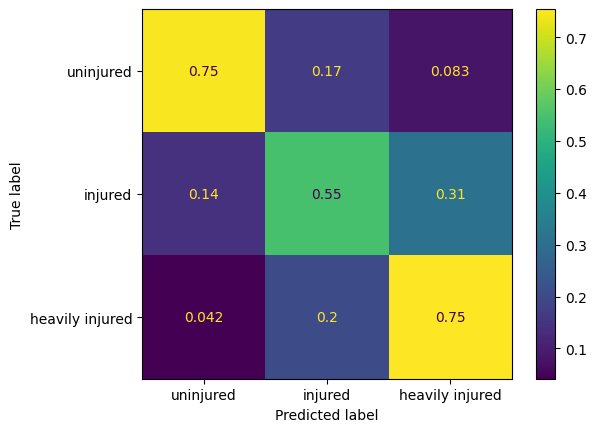

In [ ]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

### Ordinal Classification

In [ ]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('undersample', RandomUnderSampler(sampling_strategy='not minority')),
    ('classifier', LogisticAT())
])

search_grid = {
    'classifier__alpha': [0.1, 1, 10]
}

randomized_search = RandomizedSearchCV(estimator=pipeline, scoring='f1_macro', n_jobs=3, random_state=42, param_distributions=search_grid)

randomized_search.fit(X_train, y_train)

print(f'Best params: {randomized_search.best_params_}')
print(f'Best score: {randomized_search.best_score_}')

c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best params: {'classifier__alpha': 1}
Best score: 0.6160105740346877


c:\Users\David\Desktop\PythonKurs\Data Mining I\Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


              precision    recall  f1-score   support

           0       0.88      0.68      0.76     51051
           1       0.53      0.60      0.56     39476
           2       0.45      0.63      0.53     17440

    accuracy                           0.64    107967
   macro avg       0.62      0.63      0.62    107967
weighted avg       0.68      0.64      0.65    107967



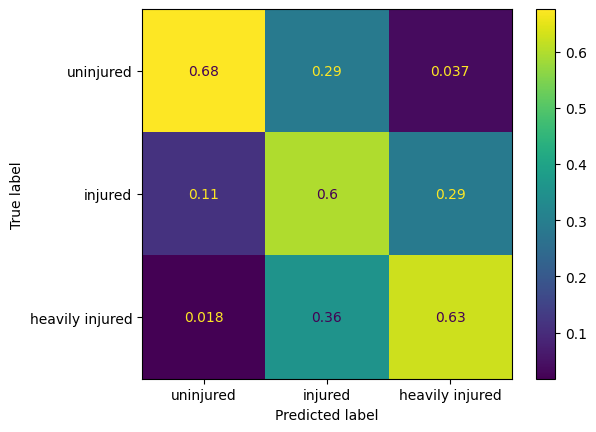

In [ ]:
y_pred = randomized_search.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

### Lasso Regression

In [ ]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', MinMaxScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('undersample', RandomUnderSampler(sampling_strategy='not minority')),
    ('classifier', LassoCV(n_jobs=-1))
])

c:\Users\David\Desktop\PythonKurs\Data_Mining_I\Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.596e+01, tolerance: 8.338e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\David\Desktop\PythonKurs\Data_Mining_I\Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.873e+01, tolerance: 8.338e+00
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\David\Desktop\PythonKurs\Data_Mining_I\Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the numb

              precision    recall  f1-score   support

           0       0.90      0.63      0.74     51051
           1       0.51      0.57      0.54     39476
           2       0.43      0.68      0.53     17440

    accuracy                           0.62    107967
   macro avg       0.61      0.63      0.60    107967
weighted avg       0.68      0.62      0.63    107967



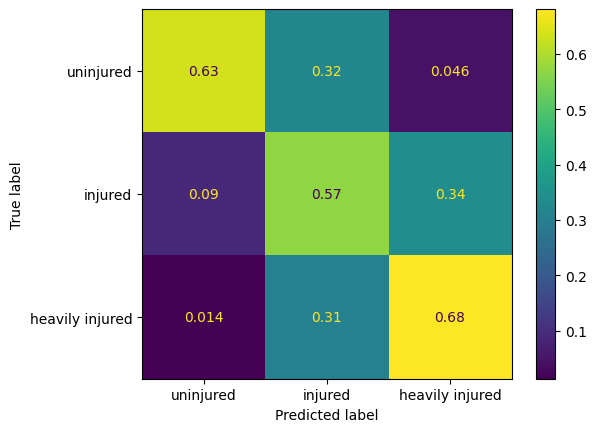

In [ ]:
under_sampler = RandomUnderSampler(sampling_strategy='not minority', replacement=True) 
X_tr, y_tr = under_sampler.fit_resample(X_train, y_train)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.2, shuffle=True
)

pipeline.fit(X_tr, y_tr)
y_val_cont = pipeline.predict(X_val)

# Helpers to convert continuous preds to ordinal classes
def round_clip(y_cont):
    return np.clip(np.rint(y_cont), 0, 2).astype(int)

def apply_thresholds(y_cont, t1, t2):
    y = np.asarray(y_cont)
    out = np.empty_like(y, dtype=int)
    out[y < t1] = 0
    out[(y >= t1) & (y < t2)] = 1
    out[(y >= t2)] = 2
    return out

# Tune ordinal thresholds on validation
best = (-1, (0.5, 1.5, 2.5))
g1 = np.arange(0.3, 0.8, 0.01)
g2 = np.arange(1.3, 1.8, 0.01)
for t1 in g1:
    for t2 in g2:
        if t2 <= t1: 
            continue
        yv = apply_thresholds(y_val_cont, t1, t2)
        score = f1_score(y_val, yv, average='macro')
        if score > best[0]:
            best = (score, (t1, t2))

score, (t1, t2) = best


y_pred_cont = pipeline.predict(X_test)
y_pred = apply_thresholds(y_pred_cont, t1, t2)


print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

### Ridge Regression

In [ ]:
transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num', StandardScaler(), num_cols)
], remainder='passthrough')

pipeline = ImbPipeline(steps=[
    ('transform', transformer),
    ('undersample', RandomUnderSampler(sampling_strategy='not minority')),
    ('classifier', RidgeCV(scoring='neg_root_mean_squared_error'))
])

              precision    recall  f1-score   support

           0       0.88      0.65      0.75     51051
           1       0.51      0.56      0.53     39476
           2       0.43      0.66      0.52     17440

    accuracy                           0.62    107967
   macro avg       0.61      0.62      0.60    107967
weighted avg       0.67      0.62      0.63    107967



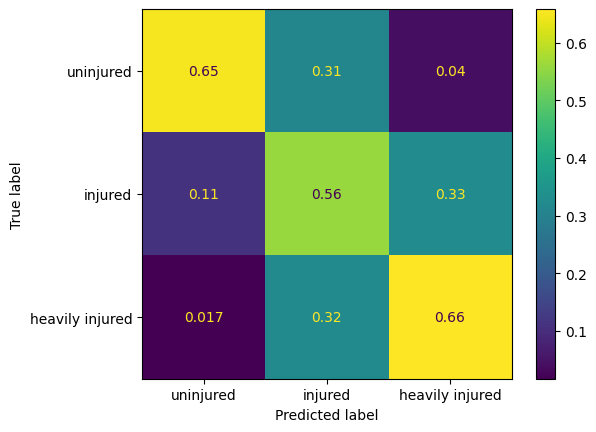

In [ ]:
under_sampler = RandomUnderSampler(sampling_strategy='not minority', replacement=True) 

X_tr, y_tr = under_sampler.fit_resample(X_train, y_train)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.2, shuffle=True
)

pipeline.fit(X_tr, y_tr)
y_val_cont = pipeline.predict(X_val)

# Helpers to convert continuous preds to ordinal classes
def round_clip(y_cont):
    return np.clip(np.rint(y_cont), 0, 2).astype(int)

def apply_thresholds(y_cont, t1, t2):
    y = np.asarray(y_cont)
    out = np.empty_like(y, dtype=int)
    out[y < t1] = 0
    out[(y >= t1) & (y < t2)] = 1
    out[(y >= t2)] = 2
    return out

# Tune ordinal thresholds on validation
best = (-1, (0.5, 1.5, 2.5))
g1 = np.arange(0.05, 0.95, 0.01)
g2 = np.arange(1.05, 1.95, 0.01)
for t1 in g1:
    for t2 in g2:
        if t2 <= t1: 
            continue
        yv = apply_thresholds(y_val_cont, t1, t2)
        score = f1_score(y_val, yv, average='macro')
        if score > best[0]:
            best = (score, (t1, t2))

score, (t1, t2) = best


y_pred_cont = pipeline.predict(X_test)
y_pred = apply_thresholds(y_pred_cont, t1, t2)
#y_pred = round_clip(y_pred_cont)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

In [ ]:
coef = pipeline.steps[2][1].coef_
feature_names = pipeline.steps[0][1].get_feature_names_out()

df_coef = pd.DataFrame({
    'feature': feature_names,
    'coef': coef
})

df_coef.sort_values(by='coef', ascending=False).head(50)

,feature,coef
200,cat__vehicle_category_simplified_other_no vehicle,0.703940
195,cat__vehicle_category_simplified_powered_2_3_w...,0.576069
201,cat__vehicle_category_simplified_other_other,0.481944
137,cat__mobile_obstacle_struck_4,0.466457
9,cat__age_group_senior,0.421015
177,cat__sex_2,0.393042
176,cat__sex_1,0.310060
199,cat__vehicle_category_simplified_other_light_m...,0.251032
8,cat__age_group_middle_aged,0.245079
56,cat__infrastructure_7,0.230458


c:\Users\David\Desktop\PythonKurs\Data_Mining_I\Project\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:246: UserWarning: Found unknown categories in columns [25] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


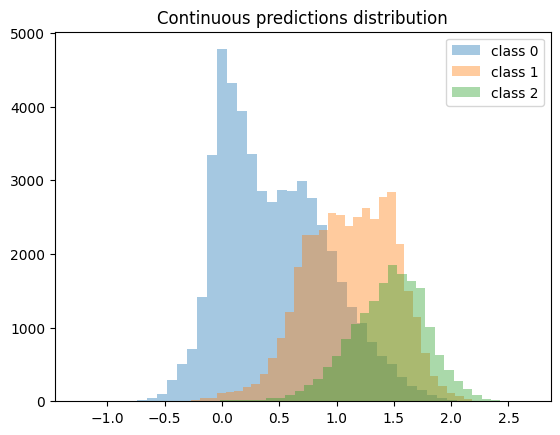

In [ ]:
import matplotlib.pyplot as plt
y_cont_test = pipeline.predict(X_test)
for cls in [0,1,2]:
    plt.hist(y_cont_test[y_test==cls], bins=40, alpha=0.4, label=f'class {cls}')
plt.legend(); plt.title('Continuous predictions distribution'); plt.show()

### HistGradientBoostingClassifier

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

transformer = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('num', 'passthrough', num_cols)
], remainder='drop')

X_tr = transformer.fit_transform(X_train)
X_te = transformer.transform(X_test)

# Categorical cols are first block -> indices 0 .. len(cat_cols)-1
cat_idx = list(range(len(cat_cols)))

sw = compute_sample_weight(class_weight='balanced', y=y_train)

gb = HistGradientBoostingClassifier(
    categorical_features=cat_idx,
    learning_rate=0.05,
    max_depth=6,
    max_iter=300,
    min_samples_leaf=50,
    l2_regularization=1.0
)

gb.fit(X_tr, y_train, sample_weight=sw)

,loss,'log_loss'
,learning_rate,0.05
,max_iter,300
,max_leaf_nodes,31
,max_depth,6
,min_samples_leaf,50
,l2_regularization,1.0
,max_features,1.0
,max_bins,255
,categorical_features,"[0, 1, ...]"
,monotonic_cst,None


              precision    recall  f1-score   support

           0       0.87      0.75      0.81     51051
           1       0.64      0.61      0.63     39476
           2       0.48      0.71      0.57     17440

    accuracy                           0.69    107967
   macro avg       0.66      0.69      0.67    107967
weighted avg       0.72      0.69      0.70    107967



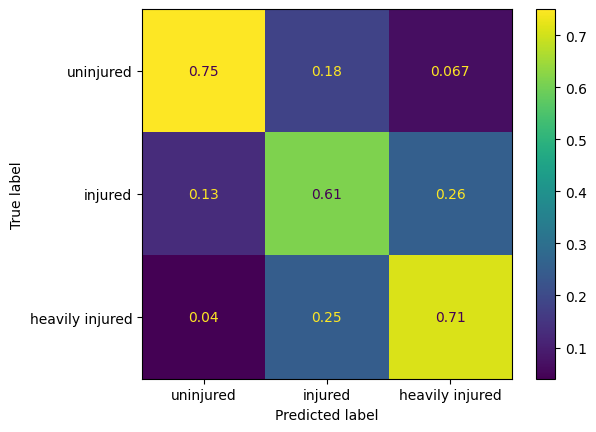

In [ ]:
y_pred = gb.predict(X_te)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

#### Hyperparameter Tuning

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params: {'min_samples_leaf': 80, 'max_leaf_nodes': 63, 'max_iter': 700, 'max_depth': 6, 'learning_rate': np.float64(0.05352681822847106), 'l2_regularization': np.float64(27.825594022071257), 'early_stopping': 'auto'}
Best CV macro F1: 0.6946536458643342
              precision    recall  f1-score   support

           0       0.87      0.75      0.81     51051
           1       0.64      0.62      0.63     39476
           2       0.48      0.70      0.57     17440

    accuracy                           0.70    107967
   macro avg       0.66      0.69      0.67    107967
weighted avg       0.72      0.70      0.70    107967



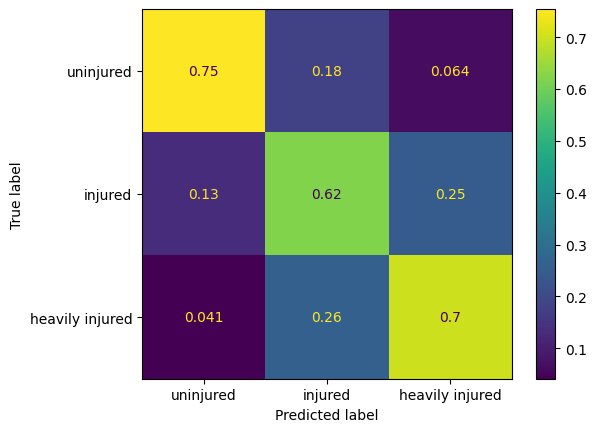

In [ ]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer
from sklearn.model_selection import RandomizedSearchCV

# Reuse already created transformer, X_tr, X_te, cat_idx, sw (sample weights), y_train, y_test.
# If this cell is run standalone, uncomment the following line to rebuild X_tr / X_te:
# X_tr = transformer.fit_transform(X_train); X_te = transformer.transform(X_test)

base_clf = HistGradientBoostingClassifier(
    categorical_features=cat_idx,
    random_state=42
)

param_distributions = {
    "learning_rate": np.logspace(-2.3, -0.7, 15),        # ~0.005 to ~0.2
    "max_depth": [None, 4, 6, 8],
    "max_leaf_nodes": [31, 63, 127],
    "min_samples_leaf": [20, 30, 50, 80, 120],
    "l2_regularization": np.logspace(-3, 2, 10),
    "early_stopping": ["auto"],                          # keep auto
    "max_iter": [400, 700, 1000]
}

scorer = make_scorer(f1_score, average='macro')

search = RandomizedSearchCV(
    estimator=base_clf,
    param_distributions=param_distributions,
    n_iter=20,
    scoring=scorer,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=2
)

search.fit(X_tr, y_train, sample_weight=sw)

print("Best params:", search.best_params_)
print("Best CV macro F1:", search.best_score_)

best_clf = search.best_estimator_
y_pred = best_clf.predict(X_te)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

#### Hierarchical Model

Hierarchical thresholds t1(injury)=0.42, t2(heavy)=0.62, weighted score=0.650
Raw hierarchical (argmax) macro F1: 0.6630993347011563
Tuned hierarchical macro F1: 0.6754484392278033
              precision    recall  f1-score   support

           0       0.88      0.74      0.80     51051
           1       0.61      0.73      0.67     39476
           2       0.55      0.57      0.56     17440

    accuracy                           0.71    107967
   macro avg       0.68      0.68      0.68    107967
weighted avg       0.73      0.71      0.71    107967



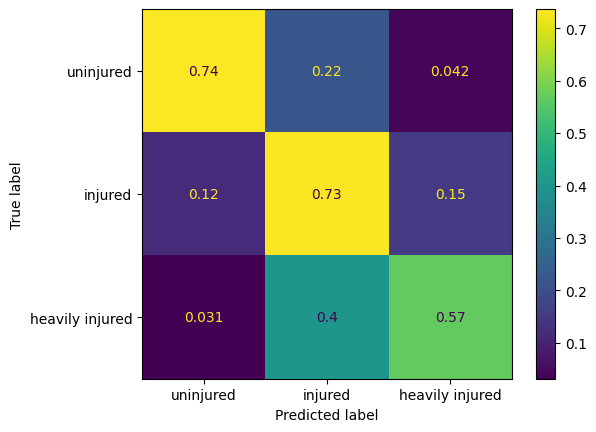

In [ ]:
# Hierarchical two-stage model: (0 vs 1+2) then (1 vs 2)
import numpy as np
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Transformer (ordinal encode categorical, pass numeric)
hier_transformer = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('num', 'passthrough', num_cols)
], remainder='drop')

X_tr_full = hier_transformer.fit_transform(X_train)
X_te_full = hier_transformer.transform(X_test)
cat_idx_hier = list(range(len(cat_cols)))

# Stage 1: any injury (1 or 2) vs none (0)
y_stage1 = (y_train >= 1).astype(int)
sw1 = compute_sample_weight(class_weight='balanced', y=y_stage1)

# Best params from above: {'min_samples_leaf': 80, 'max_leaf_nodes': 63, 'max_iter': 700, 'max_depth': 6, 'learning_rate': np.float64(0.05352681822847106), 'l2_regularization': np.float64(27.825594022071257), 'early_stopping': 'auto'}

stage1_clf = HistGradientBoostingClassifier(
    categorical_features=cat_idx_hier,
    learning_rate=0.05352681822847106,
    max_depth=6,
    max_iter=700,
    min_samples_leaf=63,
    l2_regularization=27.825594022071257,
    random_state=42
)
stage1_clf.fit(X_tr_full, y_stage1, sample_weight=sw1)

# Stage 2: heavy (2) vs light (1) among injured
inj_mask = (y_train >= 1)
X_tr_inj = X_tr_full[inj_mask]
y_stage2 = (y_train[inj_mask] == 2).astype(int)
sw2 = compute_sample_weight(class_weight='balanced', y=y_stage2)

stage2_clf = HistGradientBoostingClassifier(
    categorical_features=cat_idx_hier,
    learning_rate=0.05352681822847106,
    max_depth=6,
    max_iter=700,
    min_samples_leaf=63,
    l2_regularization=27.825594022071257,
    random_state=43
)
stage2_clf.fit(X_tr_inj, y_stage2, sample_weight=sw2)

# Predict probabilities
p_inj = stage1_clf.predict_proba(X_te_full)[:, 1]          # P(y>=1)
p_heavy_cond = stage2_clf.predict_proba(X_te_full)[:, 1]   # Approx P(y=2 | y>=1) (used on all for simplicity)

# Combine hierarchically
p2 = p_inj * p_heavy_cond
p0 = 1.0 - p_inj
p1 = p_inj - p2
probs = np.c_[p0, p1, p2]
probs = np.clip(probs, 0, 1)
probs = probs / probs.sum(axis=1, keepdims=True)

# Raw argmax prediction
y_pred_raw = np.argmax(probs, axis=1)

# Threshold tuning (t1 for injury, t2 for heavy) to boost classes 1 & 2
def predict_with_thresholds(p_inj, p_heavy, t1, t2):
    out = np.zeros_like(p_inj, dtype=int)
    inj_mask = p_inj >= t1
    heavy_mask = (p_heavy >= t2) & inj_mask
    out[inj_mask] = 1
    out[heavy_mask] = 2
    return out

def tune_thresholds_weighted(y_true, p_inj, p_heavy, g1, g2, weights=(0.2, 0.4, 0.4)):
    best = (-1, (None, None))
    for t1 in g1:
        for t2 in g2:
            if t2 > 1 or t1 > 1: continue
            y_hat = predict_with_thresholds(p_inj, p_heavy, t1, t2)
            # Per-class F1
            f1_0 = f1_score(y_true == 0, y_hat == 0)
            f1_1 = f1_score(y_true == 1, y_hat == 1)
            f1_2 = f1_score(y_true == 2, y_hat == 2)
            score = weights[0]*f1_0 + weights[1]*f1_1 + weights[2]*f1_2
            # Ensure minimum recall for class 2
            cm = confusion_matrix(y_true, y_hat, labels=[0,1,2])
            recall_2 = cm[2,2] / cm[2].sum() if cm[2].sum() else 0
            if recall_2 < 0.5:
                continue
            if score > best[0]:
                best = (score, (t1, t2))
    return best

g1 = np.arange(0.3, 0.85, 0.02)   # injury threshold grid
g2 = np.arange(0.3, 0.85, 0.02)   # heavy threshold grid
best_score, (best_t1, best_t2) = tune_thresholds_weighted(y_test.values, p_inj, p_heavy_cond, g1, g2)

y_pred_hier = predict_with_thresholds(p_inj, p_heavy_cond, best_t1, best_t2)

print(f"Hierarchical thresholds t1(injury)={best_t1:.2f}, t2(heavy)={best_t2:.2f}, weighted score={best_score:.3f}")
print("Raw hierarchical (argmax) macro F1:", f1_score(y_test, y_pred_raw, average='macro'))
print("Tuned hierarchical macro F1:", f1_score(y_test, y_pred_hier, average='macro'))

print(classification_report(y_test, y_pred_hier))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_hier, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

### CatBoostClassifier

In [ ]:
from catboost import CatBoostClassifier

cat_idx = [X_train.columns.get_loc(c) for c in X_train.columns if c not in num_cols]

model = CatBoostClassifier(
    loss_function='MultiClassOneVsAll',
    eval_metric='TotalF1',
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced',
    #boosting_type='Ordered',
    cat_features=cat_idx
)
model.fit(X_train, y_train)

0:	learn: 0.5720124	total: 108ms	remaining: 1m 47s
1:	learn: 0.5720124	total: 215ms	remaining: 1m 47s
2:	learn: 0.5729070	total: 273ms	remaining: 1m 30s
3:	learn: 0.5730494	total: 296ms	remaining: 1m 13s
4:	learn: 0.5730494	total: 320ms	remaining: 1m 3s
5:	learn: 0.5808668	total: 343ms	remaining: 56.8s
6:	learn: 0.5725437	total: 366ms	remaining: 51.9s
7:	learn: 0.5818551	total: 389ms	remaining: 48.2s
8:	learn: 0.5843815	total: 412ms	remaining: 45.4s
9:	learn: 0.5847415	total: 435ms	remaining: 43.1s
10:	learn: 0.5847415	total: 458ms	remaining: 41.2s
11:	learn: 0.5854638	total: 478ms	remaining: 39.4s
12:	learn: 0.5854692	total: 498ms	remaining: 37.8s
13:	learn: 0.5854595	total: 518ms	remaining: 36.4s
14:	learn: 0.5856815	total: 537ms	remaining: 35.3s
15:	learn: 0.5864196	total: 562ms	remaining: 34.5s
16:	learn: 0.5868301	total: 581ms	remaining: 33.6s
17:	learn: 0.5866471	total: 600ms	remaining: 32.7s
18:	learn: 0.5873908	total: 621ms	remaining: 32s
19:	learn: 0.5872912	total: 641ms	remai

              precision    recall  f1-score   support

           0       0.86      0.75      0.80     51051
           1       0.65      0.62      0.63     39476
           2       0.48      0.72      0.58     17440

    accuracy                           0.70    107967
   macro avg       0.66      0.70      0.67    107967
weighted avg       0.72      0.70      0.70    107967



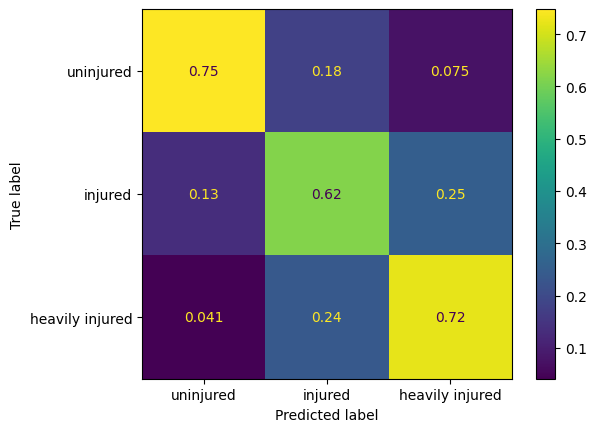

In [ ]:
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

#### CatBoostClassifier - Hierarchical Ordered

Learning rate set to 0.024186
0:	learn: 0.7953609	total: 334ms	remaining: 5m 33s
1:	learn: 0.7953837	total: 565ms	remaining: 4m 42s
2:	learn: 0.7995424	total: 808ms	remaining: 4m 28s
3:	learn: 0.7995403	total: 1.05s	remaining: 4m 21s
4:	learn: 0.7980155	total: 1.31s	remaining: 4m 20s
5:	learn: 0.7979928	total: 1.55s	remaining: 4m 17s
6:	learn: 0.7979867	total: 1.79s	remaining: 4m 14s
7:	learn: 0.7980191	total: 2.02s	remaining: 4m 10s
8:	learn: 0.7980235	total: 2.27s	remaining: 4m 9s
9:	learn: 0.7980160	total: 2.5s	remaining: 4m 7s
10:	learn: 0.7980634	total: 2.75s	remaining: 4m 7s
11:	learn: 0.7980657	total: 3s	remaining: 4m 6s
12:	learn: 0.7984559	total: 3.25s	remaining: 4m 6s
13:	learn: 0.7984485	total: 3.48s	remaining: 4m 5s
14:	learn: 0.7984103	total: 3.73s	remaining: 4m 4s
15:	learn: 0.7990238	total: 3.99s	remaining: 4m 5s
16:	learn: 0.7991998	total: 4.24s	remaining: 4m 5s
17:	learn: 0.7975076	total: 4.51s	remaining: 4m 6s
18:	learn: 0.7992642	total: 4.74s	remaining: 4m 4s
19:	lea

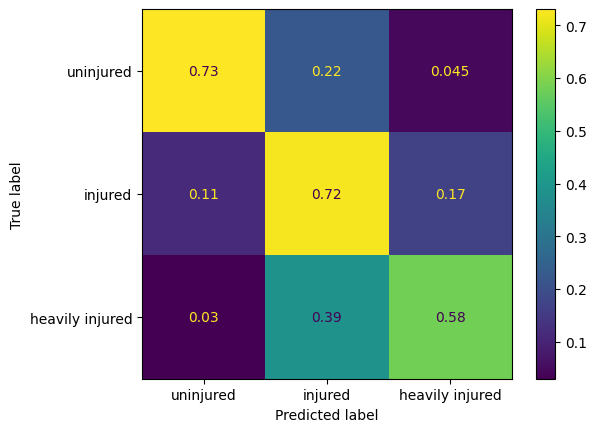

In [ ]:
# Hierarchical two-stage model: (0 vs 1+2) then (1 vs 2)
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier

# Transformer (ordinal encode categorical, pass numeric)
# hier_transformer = ColumnTransformer([
#     ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.int32), cat_cols),
#     ('num', 'passthrough', num_cols)
# ], remainder='drop')

# X_tr_full = hier_transformer.fit_transform(X_train)
# X_te_full = hier_transformer.transform(X_test)

# Stage 1: any injury (1 or 2) vs none (0)

cat_idx = [X_train.columns.get_loc(c) for c in X_train.columns if c not in num_cols]

y_stage1 = (y_train >= 1).astype(int)

stage1_clf = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='TotalF1',
    task_type='GPU',
    devices='0',
    boosting_type='Ordered',
    auto_class_weights='Balanced',
    cat_features=cat_idx
)

stage1_clf.fit(X_train, y_stage1)

# Stage 2: heavy (2) vs light (1) among injured
inj_mask = (y_train >= 1)
X_tr_inj = X_train[inj_mask]
y_stage2 = (y_train[inj_mask] == 2).astype(int)

stage2_clf = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='TotalF1',
    task_type='GPU',
    devices='0',
    boosting_type='Ordered',
    auto_class_weights='Balanced',
    cat_features=cat_idx
)

stage2_clf.fit(X_tr_inj, y_stage2)

# Predict probabilities
p_inj = stage1_clf.predict_proba(X_test)[:, 1]          # P(y>=1)
p_heavy_cond = stage2_clf.predict_proba(X_test)[:, 1]   # Approx P(y=2 | y>=1) (used on all for simplicity)

# Combine hierarchically
p2 = p_inj * p_heavy_cond
p0 = 1.0 - p_inj
p1 = p_inj - p2
probs = np.c_[p0, p1, p2]
probs = np.clip(probs, 0, 1)
probs = probs / probs.sum(axis=1, keepdims=True)

# Raw argmax prediction
y_pred_raw = np.argmax(probs, axis=1)

# Threshold tuning (t1 for injury, t2 for heavy) to boost classes 1 & 2
def predict_with_thresholds(p_inj, p_heavy, t1, t2):
    out = np.zeros_like(p_inj, dtype=int)
    inj_mask = p_inj >= t1
    heavy_mask = (p_heavy >= t2) & inj_mask
    out[inj_mask] = 1
    out[heavy_mask] = 2
    return out

def tune_thresholds_weighted(y_true, p_inj, p_heavy, g1, g2, weights=(0.2, 0.4, 0.4)):
    best = (-1, (None, None))
    for t1 in g1:
        for t2 in g2:
            if t2 > 1 or t1 > 1: continue
            y_hat = predict_with_thresholds(p_inj, p_heavy, t1, t2)
            # Per-class F1
            f1_0 = f1_score(y_true == 0, y_hat == 0)
            f1_1 = f1_score(y_true == 1, y_hat == 1)
            f1_2 = f1_score(y_true == 2, y_hat == 2)
            score = weights[0]*f1_0 + weights[1]*f1_1 + weights[2]*f1_2
            # Ensure minimum recall for class 2
            cm = confusion_matrix(y_true, y_hat, labels=[0,1,2])
            recall_2 = cm[2,2] / cm[2].sum() if cm[2].sum() else 0
            if recall_2 < 0.5:
                continue
            if score > best[0]:
                best = (score, (t1, t2))
    return best

g1 = np.arange(0.3, 0.85, 0.02)   # injury threshold grid
g2 = np.arange(0.3, 0.85, 0.02)   # heavy threshold grid
best_score, (best_t1, best_t2) = tune_thresholds_weighted(y_test.values, p_inj, p_heavy_cond, g1, g2)

y_pred_hier = predict_with_thresholds(p_inj, p_heavy_cond, best_t1, best_t2)

print(f"Hierarchical thresholds t1(injury)={best_t1:.2f}, t2(heavy)={best_t2:.2f}, weighted score={best_score:.3f}")
print("Raw hierarchical (argmax) macro F1:", f1_score(y_test, y_pred_raw, average='macro'))
print("Tuned hierarchical macro F1:", f1_score(y_test, y_pred_hier, average='macro'))

print(classification_report(y_test, y_pred_hier))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_hier, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

#### CatBoostClassifier - Hierarchical

Learning rate set to 0.024186
0:	learn: 0.7996912	total: 426ms	remaining: 7m 5s
1:	learn: 0.8032730	total: 583ms	remaining: 4m 51s
2:	learn: 0.8033216	total: 723ms	remaining: 4m
3:	learn: 0.8032712	total: 880ms	remaining: 3m 39s
4:	learn: 0.8022429	total: 1.04s	remaining: 3m 26s
5:	learn: 0.8022417	total: 1.2s	remaining: 3m 18s
6:	learn: 0.8022761	total: 1.34s	remaining: 3m 10s
7:	learn: 0.8022582	total: 1.5s	remaining: 3m 5s
8:	learn: 0.8022634	total: 1.66s	remaining: 3m 2s
9:	learn: 0.8022549	total: 1.79s	remaining: 2m 57s
10:	learn: 0.8022591	total: 1.95s	remaining: 2m 55s
11:	learn: 0.8022636	total: 2.11s	remaining: 2m 53s
12:	learn: 0.8025357	total: 2.27s	remaining: 2m 52s
13:	learn: 0.8025303	total: 2.42s	remaining: 2m 50s
14:	learn: 0.8025069	total: 2.58s	remaining: 2m 49s
15:	learn: 0.8028241	total: 2.74s	remaining: 2m 48s
16:	learn: 0.8029074	total: 2.91s	remaining: 2m 48s
17:	learn: 0.8028672	total: 3.07s	remaining: 2m 47s
18:	learn: 0.8029040	total: 3.21s	remaining: 2m 45s
1

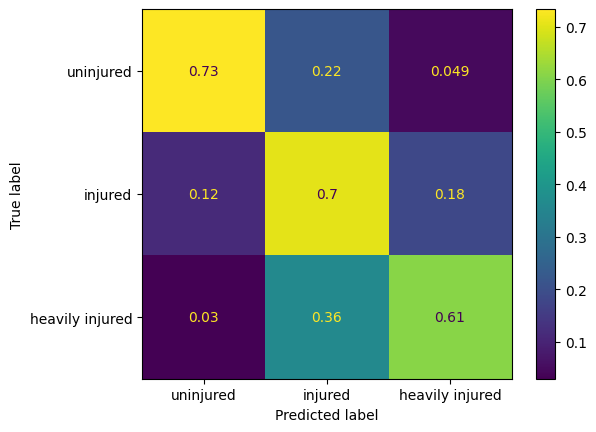

In [ ]:
# Hierarchical two-stage model: (0 vs 1+2) then (1 vs 2)
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier

# Transformer (ordinal encode categorical, pass numeric)
# hier_transformer = ColumnTransformer([
#     ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, dtype=np.int32), cat_cols),
#     ('num', 'passthrough', num_cols)
# ], remainder='drop')

# X_tr_full = hier_transformer.fit_transform(X_train)
# X_te_full = hier_transformer.transform(X_test)

# Stage 1: any injury (1 or 2) vs none (0)

cat_idx = [X_train.columns.get_loc(c) for c in X_train.columns if c not in num_cols]

y_stage1 = (y_train >= 1).astype(int)

stage1_clf = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced',
    cat_features=cat_idx
)

stage1_clf.fit(X_train, y_stage1)

# Stage 2: heavy (2) vs light (1) among injured
inj_mask = (y_train >= 1)
X_tr_inj = X_train[inj_mask]
y_stage2 = (y_train[inj_mask] == 2).astype(int)

stage2_clf = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced',
    cat_features=cat_idx
)

stage2_clf.fit(X_tr_inj, y_stage2)

# Predict probabilities
p_inj = stage1_clf.predict_proba(X_test)[:, 1]          # P(y>=1)
p_heavy_cond = stage2_clf.predict_proba(X_test)[:, 1]   # Approx P(y=2 | y>=1) (used on all for simplicity)

# Combine hierarchically
p2 = p_inj * p_heavy_cond
p0 = 1.0 - p_inj
p1 = p_inj - p2
probs = np.c_[p0, p1, p2]
probs = np.clip(probs, 0, 1)
probs = probs / probs.sum(axis=1, keepdims=True)

# Raw argmax prediction
y_pred_raw = np.argmax(probs, axis=1)

# Threshold tuning (t1 for injury, t2 for heavy) to boost classes 1 & 2
def predict_with_thresholds(p_inj, p_heavy, t1, t2):
    out = np.zeros_like(p_inj, dtype=int)
    inj_mask = p_inj >= t1
    heavy_mask = (p_heavy >= t2) & inj_mask
    out[inj_mask] = 1
    out[heavy_mask] = 2
    return out

def tune_thresholds_weighted(y_true, p_inj, p_heavy, g1, g2, weights=(0.2, 0.4, 0.4)):
    best = (-1, (None, None))
    for t1 in g1:
        for t2 in g2:
            if t2 > 1 or t1 > 1: continue
            y_hat = predict_with_thresholds(p_inj, p_heavy, t1, t2)
            # Per-class F1
            f1_0 = f1_score(y_true == 0, y_hat == 0)
            f1_1 = f1_score(y_true == 1, y_hat == 1)
            f1_2 = f1_score(y_true == 2, y_hat == 2)
            score = weights[0]*f1_0 + weights[1]*f1_1 + weights[2]*f1_2
            # Ensure minimum recall for class 2
            cm = confusion_matrix(y_true, y_hat, labels=[0,1,2])
            recall_2 = cm[2,2] / cm[2].sum() if cm[2].sum() else 0
            if recall_2 < 0.5:
                continue
            if score > best[0]:
                best = (score, (t1, t2))
    return best

g1 = np.arange(0.3, 0.85, 0.02)   # injury threshold grid
g2 = np.arange(0.3, 0.85, 0.02)   # heavy threshold grid
best_score, (best_t1, best_t2) = tune_thresholds_weighted(y_test.values, p_inj, p_heavy_cond, g1, g2)

y_pred_hier = predict_with_thresholds(p_inj, p_heavy_cond, best_t1, best_t2)

print(f"Hierarchical thresholds t1(injury)={best_t1:.2f}, t2(heavy)={best_t2:.2f}, weighted score={best_score:.3f}")
print("Raw hierarchical (argmax) macro F1:", f1_score(y_test, y_pred_raw, average='macro'))
print("Tuned hierarchical macro F1:", f1_score(y_test, y_pred_hier, average='macro'))

print(classification_report(y_test, y_pred_hier))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred_hier, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

#### CatBoostClassifier - OneVsRestClassifier

In [ ]:
from sklearn.multiclass import OneVsRestClassifier

catBoost = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='TotalF1',
    task_type='GPU',
    devices='0',
    boosting_type='Ordered',
    auto_class_weights='Balanced',
    cat_features=cat_idx
)

estimator = OneVsRestClassifier(estimator=catBoost)

estimator.fit(X_train, y_train)

Learning rate set to 0.024186
0:	learn: 0.7955055	total: 499ms	remaining: 8m 18s
1:	learn: 0.7954322	total: 723ms	remaining: 6m
2:	learn: 0.7954269	total: 950ms	remaining: 5m 15s
3:	learn: 0.7990720	total: 1.17s	remaining: 4m 51s
4:	learn: 0.7960325	total: 1.39s	remaining: 4m 37s
5:	learn: 0.7991390	total: 1.63s	remaining: 4m 30s
6:	learn: 0.7988343	total: 1.88s	remaining: 4m 26s
7:	learn: 0.7985444	total: 2.1s	remaining: 4m 20s
8:	learn: 0.7991050	total: 2.32s	remaining: 4m 15s
9:	learn: 0.7984609	total: 2.55s	remaining: 4m 12s
10:	learn: 0.7985522	total: 2.77s	remaining: 4m 9s
11:	learn: 0.7984911	total: 3s	remaining: 4m 6s
12:	learn: 0.7987624	total: 3.23s	remaining: 4m 5s
13:	learn: 0.7987720	total: 3.46s	remaining: 4m 3s
14:	learn: 0.7989131	total: 3.69s	remaining: 4m 2s
15:	learn: 0.7990581	total: 3.91s	remaining: 4m
16:	learn: 0.7990815	total: 4.14s	remaining: 3m 59s
17:	learn: 0.7990793	total: 4.37s	remaining: 3m 58s
18:	learn: 0.7989757	total: 4.59s	remaining: 3m 57s
19:	learn

,estimator,<catboost.cor...001F21A5E6360>
,n_jobs,None
,verbose,0


              precision    recall  f1-score   support

           0       0.87      0.75      0.80     51051
           1       0.63      0.65      0.64     39476
           2       0.49      0.66      0.56     17440

    accuracy                           0.70    107967
   macro avg       0.66      0.69      0.67    107967
weighted avg       0.72      0.70      0.71    107967



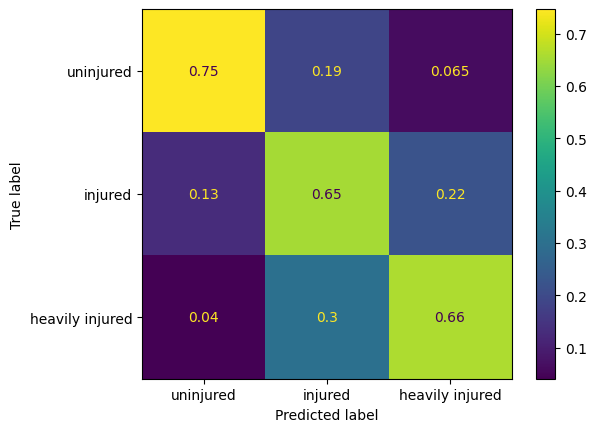

In [ ]:
y_pred = estimator.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

#### CatBoostClassifier - Undersampling

In [ ]:
classifier = CatBoostClassifier(
    loss_function='MultiClassOneVsAll',
    eval_metric='TotalF1',
    # eval_metric='MultiClassOneVsAll',
    # task_type='GPU',
    # devices='0',
    boosting_type='Ordered',
    cat_features=cat_idx,
    # verbose=False
)

pipeline = ImbPipeline([
    ('under_sampler', RandomUnderSampler(sampling_strategy={0:5000, 1:5000, 2:5000})),
    ('classifier', classifier)
])

pipeline.fit(X_train, y_train)

0:	learn: 0.6828018	total: 212ms	remaining: 3m 32s
1:	learn: 0.6730645	total: 418ms	remaining: 3m 28s
2:	learn: 0.6639929	total: 670ms	remaining: 3m 42s
3:	learn: 0.6554287	total: 897ms	remaining: 3m 43s
4:	learn: 0.6472192	total: 1.11s	remaining: 3m 40s
5:	learn: 0.6392828	total: 1.33s	remaining: 3m 40s
6:	learn: 0.6317665	total: 1.52s	remaining: 3m 35s
7:	learn: 0.6244362	total: 1.72s	remaining: 3m 32s
8:	learn: 0.6177453	total: 1.94s	remaining: 3m 34s
9:	learn: 0.6115079	total: 2.17s	remaining: 3m 35s
10:	learn: 0.6054985	total: 2.38s	remaining: 3m 34s
11:	learn: 0.5999261	total: 2.6s	remaining: 3m 33s
12:	learn: 0.5945041	total: 2.82s	remaining: 3m 34s
13:	learn: 0.5890449	total: 3.05s	remaining: 3m 34s
14:	learn: 0.5839996	total: 3.27s	remaining: 3m 34s
15:	learn: 0.5790336	total: 3.49s	remaining: 3m 34s
16:	learn: 0.5742712	total: 3.71s	remaining: 3m 34s
17:	learn: 0.5696345	total: 3.92s	remaining: 3m 33s
18:	learn: 0.5655110	total: 4.14s	remaining: 3m 33s
19:	learn: 0.5613534	to

,steps,"[('under_sampler', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,"{0: 5000, 1: 5000, 2: 5000}"
,random_state,None
,replacement,False


              precision    recall  f1-score   support

           0       0.86      0.73      0.79     51051
           1       0.62      0.59      0.60     39476
           2       0.45      0.71      0.55     17440

    accuracy                           0.67    107967
   macro avg       0.64      0.67      0.65    107967
weighted avg       0.71      0.67      0.68    107967



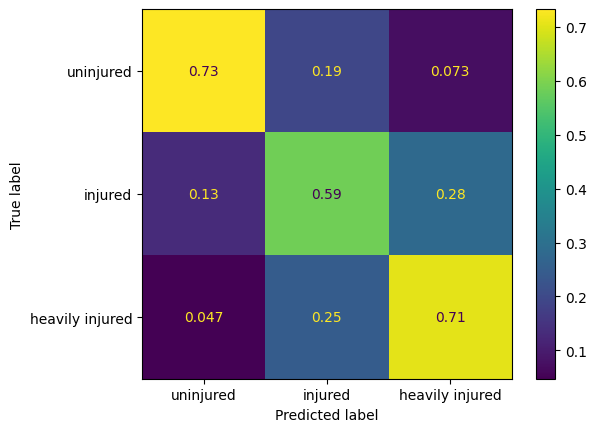

In [ ]:
y_pred = pipeline.predict(X_test)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

### CatBoost Regressor

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
import numpy as np

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

def apply_thresholds(y_cont, t1, t2):
    y = np.asarray(y_cont)
    out = np.empty_like(y, dtype=int)
    out[y < t1] = 0
    out[(y >= t1) & (y < t2)] = 1
    out[(y >= t2)] = 2
    return out

def tune_thresholds(y_true, y_score, g1, g2):
    best = (-1, (None, None))
    for t1 in g1:
        for t2 in g2:
            if t2 <= t1:
                continue
            pred = apply_thresholds(y_score, t1, t2)
            sc = f1_score(y_true, pred, average='macro')
            if sc > best[0]:
                best = (sc, (t1, t2))
    return best

def report(y_true, y_pred, title=None):
    if title: print(title)
    print(classification_report(y_true, y_pred))
    ConfusionMatrixDisplay(
        confusion_matrix(y_true, y_pred, normalize='true'),
        display_labels=['uninjured', 'injured', 'heavily injured']
    ).plot()

In [ ]:
# categorical feature indices
cat_features_idx = [X_train.columns.get_loc(c) for c in cat_cols]

# CatBoost as regressor (ordinal target 1..4)
reg = CatBoostRegressor(
    loss_function='RMSE',
    task_type='GPU',
    devices='0',
    cat_features = cat_features_idx,
)

pipeline = ImbPipeline(steps=[
    ('undersample', RandomUnderSampler(sampling_strategy='not minority')),
    ('regressor', reg)
])

Learning rate set to 0.078745
0:	learn: 0.7888618	total: 8.04ms	remaining: 8.03s
1:	learn: 0.7644530	total: 15.2ms	remaining: 7.6s
2:	learn: 0.7428879	total: 22.4ms	remaining: 7.44s
3:	learn: 0.7243665	total: 29.8ms	remaining: 7.42s
4:	learn: 0.7079123	total: 36.8ms	remaining: 7.33s
5:	learn: 0.6933953	total: 44.1ms	remaining: 7.31s
6:	learn: 0.6807026	total: 51.5ms	remaining: 7.31s
7:	learn: 0.6698653	total: 58.6ms	remaining: 7.27s
8:	learn: 0.6598449	total: 66.1ms	remaining: 7.28s
9:	learn: 0.6512035	total: 73.1ms	remaining: 7.24s
10:	learn: 0.6434828	total: 80.6ms	remaining: 7.25s
11:	learn: 0.6369236	total: 88.2ms	remaining: 7.26s
12:	learn: 0.6307271	total: 95.5ms	remaining: 7.25s
13:	learn: 0.6252700	total: 103ms	remaining: 7.25s
14:	learn: 0.6207578	total: 110ms	remaining: 7.21s
15:	learn: 0.6166748	total: 117ms	remaining: 7.2s
16:	learn: 0.6132830	total: 124ms	remaining: 7.17s
17:	learn: 0.6096727	total: 131ms	remaining: 7.13s
18:	learn: 0.6064543	total: 138ms	remaining: 7.11s


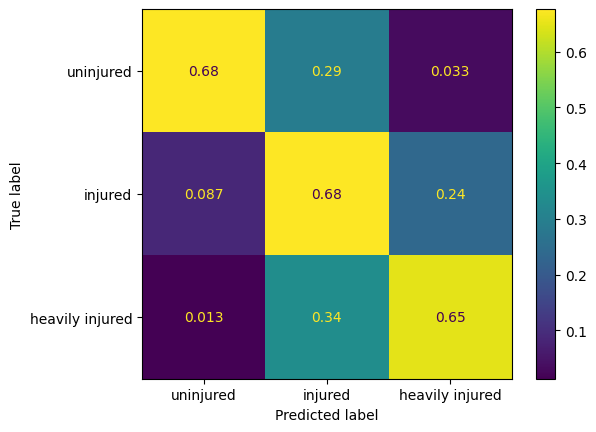

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression

nonlin_transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num_poly', Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
        ('scale', MinMaxScaler())
    ]), num_cols),
], remainder='drop')

enet = Pipeline(steps=[
    ('transform', nonlin_transformer),
    ('regressor', CatBoostRegressor(
        loss_function='RMSE',
        task_type='GPU',
        devices='0',
    ))
])


under_sampler = RandomUnderSampler(sampling_strategy='not minority')
X_tr, y_tr = under_sampler.fit_resample(X_train, y_train)

# Train/val split for calibration + thresholds
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.2, stratify=y_tr, random_state=42)

enet.fit(X_tr, y_tr)
y_val_cont = enet.predict(X_val)

# Isotonic calibration to map continuous scores onto [0,2] monotonically
iso = IsotonicRegression(y_min=0.0, y_max=2.0, increasing=True, out_of_bounds='clip')
iso.fit(y_val_cont, y_val)

# Threshold tuning on calibrated validation scores
y_val_cal = iso.predict(y_val_cont)
best_score, (t1, t2) = tune_thresholds(y_val, y_val_cal, g1=np.arange(0.2, 1.0, 0.01), g2=np.arange(1.1, 2.0, 0.01))

# Evaluate on test
y_te_cont = enet.predict(X_test)
y_te_cal = iso.predict(y_te_cont)
y_pred = apply_thresholds(y_te_cal, t1, t2)
report(y_test, y_pred, title=f"ElasticNet + interactions + isotonic (best F1={best_score:.3f}, t1={t1:.2f}, t2={t2:.2f})")

Learning rate set to 0.078739
0:	learn: 0.7888963	total: 73.1ms	remaining: 1m 12s
1:	learn: 0.7644255	total: 147ms	remaining: 1m 13s
2:	learn: 0.7430412	total: 217ms	remaining: 1m 12s
3:	learn: 0.7242538	total: 295ms	remaining: 1m 13s
4:	learn: 0.7080361	total: 358ms	remaining: 1m 11s
5:	learn: 0.6928398	total: 414ms	remaining: 1m 8s
6:	learn: 0.6796862	total: 470ms	remaining: 1m 6s
7:	learn: 0.6679693	total: 538ms	remaining: 1m 6s
8:	learn: 0.6570353	total: 594ms	remaining: 1m 5s
9:	learn: 0.6475333	total: 652ms	remaining: 1m 4s
10:	learn: 0.6397123	total: 713ms	remaining: 1m 4s
11:	learn: 0.6325503	total: 772ms	remaining: 1m 3s
12:	learn: 0.6260203	total: 838ms	remaining: 1m 3s
13:	learn: 0.6203644	total: 905ms	remaining: 1m 3s
14:	learn: 0.6153343	total: 969ms	remaining: 1m 3s
15:	learn: 0.6109622	total: 1.01s	remaining: 1m 2s
16:	learn: 0.6071468	total: 1.06s	remaining: 1m 1s
17:	learn: 0.6035182	total: 1.13s	remaining: 1m 1s
18:	learn: 0.6001206	total: 1.18s	remaining: 1m
19:	lear

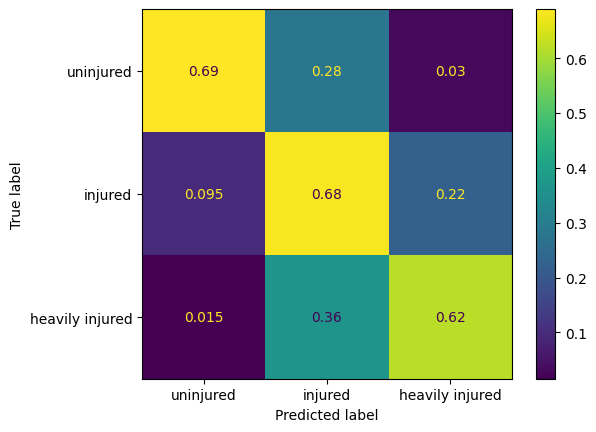

In [ ]:
under_sampler = RandomUnderSampler(sampling_strategy='not minority', replacement=True) 

X_tr, y_tr = under_sampler.fit_resample(X_train, y_train)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_tr, y_tr, test_size=0.2, shuffle=True
)

pipeline.fit(X_tr, y_tr)
y_val_cont = pipeline.predict(X_val)

# Helpers to convert continuous preds to ordinal classes
def round_clip(y_cont):
    return np.clip(np.rint(y_cont), 0, 2).astype(int)

def apply_thresholds(y_cont, t1, t2):
    y = np.asarray(y_cont)
    out = np.empty_like(y, dtype=int)
    out[y < t1] = 0
    out[(y >= t1) & (y < t2)] = 1
    out[(y >= t2)] = 2
    return out

# Tune ordinal thresholds on validation
best = (-1, (0.5, 1.5, 2.5))
g1 = np.arange(0.05, 0.95, 0.01)
g2 = np.arange(1.05, 1.95, 0.01)
for t1 in g1:
    for t2 in g2:
        if t2 <= t1: 
            continue
        yv = apply_thresholds(y_val_cont, t1, t2)
        score = f1_score(y_val, yv, average='macro')
        if score > best[0]:
            best = (score, (t1, t2))

score, (t1, t2) = best


y_pred_cont = pipeline.predict(X_test)
y_pred = apply_thresholds(y_pred_cont, t1, t2)
#y_pred = round_clip(y_pred_cont)

print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay( 
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

### ElasticNet

In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score

def apply_thresholds(y_cont, t1, t2):
    y = np.asarray(y_cont)
    out = np.empty_like(y, dtype=int)
    out[y < t1] = 0
    out[(y >= t1) & (y < t2)] = 1
    out[(y >= t2)] = 2
    return out

def tune_thresholds(y_true, y_score, g1, g2):
    best = (-1, (None, None))
    for t1 in g1:
        for t2 in g2:
            if t2 <= t1:
                continue
            pred = apply_thresholds(y_score, t1, t2)
            sc = f1_score(y_true, pred, average='macro')
            if sc > best[0]:
                best = (sc, (t1, t2))
    return best

def report(y_true, y_pred, title=None):
    if title: print(title)
    print(classification_report(y_true, y_pred))
    ConfusionMatrixDisplay(
        confusion_matrix(y_true, y_pred, normalize='true'),
        display_labels=['uninjured', 'injured', 'heavily injured']
    ).plot()

c:\Users\David\Desktop\PythonKurs\Data_Mining_I\Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1641: FutureWarning: 'alphas=None' is deprecated and will be removed in 1.9, at which point the default value will be set to 100. Set 'alphas=100' to silence this warning.
  warnings.warn(
c:\Users\David\Desktop\PythonKurs\Data_Mining_I\Project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.437e+02, tolerance: 1.089e+01
  model = cd_fast.enet_coordinate_descent(


ElasticNet + interactions + isotonic (best F1=0.638, t1=0.46, t2=1.38)
              precision    recall  f1-score   support

           0       0.90      0.62      0.74     51051
           1       0.50      0.56      0.53     39476
           2       0.43      0.69      0.53     17440

    accuracy                           0.61    107967
   macro avg       0.61      0.63      0.60    107967
weighted avg       0.68      0.61      0.63    107967



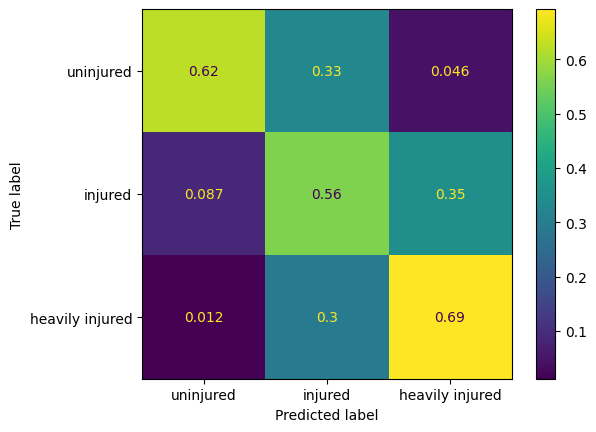

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.isotonic import IsotonicRegression

nonlin_transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num_poly', Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
        ('scale', MinMaxScaler())
    ]), num_cols),
], remainder='drop')

enet = Pipeline(steps=[
    ('transform', nonlin_transformer),
    ('enet', ElasticNetCV(l1_ratio=[0.1, 0.3, 0.5, 0.7, 0.9], alphas=None, cv=5, n_jobs=-1, random_state=42))
])

under_sampler = RandomUnderSampler(sampling_strategy='not minority')
X_tr, y_tr = under_sampler.fit_resample(X_train, y_train)

# Train/val split for calibration + thresholds
X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=0.2, stratify=y_tr, random_state=42)

enet.fit(X_tr, y_tr)
y_val_cont = enet.predict(X_val)

# Isotonic calibration to map continuous scores onto [0,2] monotonically
iso = IsotonicRegression(y_min=0.0, y_max=2.0, increasing=True, out_of_bounds='clip')
iso.fit(y_val_cont, y_val)

# Threshold tuning on calibrated validation scores
y_val_cal = iso.predict(y_val_cont)
best_score, (t1, t2) = tune_thresholds(y_val, y_val_cal, g1=np.arange(0.2, 1.0, 0.01), g2=np.arange(1.1, 2.0, 0.01))

# Evaluate on test
y_te_cont = enet.predict(X_test)
y_te_cal = iso.predict(y_te_cont)
y_pred = apply_thresholds(y_te_cal, t1, t2)
report(y_test, y_pred, title=f"ElasticNet + interactions + isotonic (best F1={best_score:.3f}, t1={t1:.2f}, t2={t2:.2f})")

### LightGBM

In [ ]:
# LightGBM with custom ordinal (cumulative link / CORAL-style) objective
import sys, subprocess, numpy as np
try:
    import lightgbm as lgb
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "lightgbm", "-q"])
    import lightgbm as lgb

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from scipy.special import expit as _sigmoid

# ------------------------------------------------------------
# Preprocessing (ordinal-encode cats; no need for LGB 'categorical_feature')
# ------------------------------------------------------------
lgb_transformer = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('num', 'passthrough', num_cols)
], remainder='drop')

X_tr_all = lgb_transformer.fit_transform(X_train)
X_te = lgb_transformer.transform(X_test)

# Train/valid split (keep stratification on original y)
X_tr, X_va, y_tr, y_va = train_test_split(
    X_tr_all, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# Recommend: prefer class weights over under-sampling (helps stability)
# If you still want RandomUnderSampler, you may keep it, but beware of huge logits.
def make_class_weights(y):
    counts = np.bincount(y.astype(int))
    weights = 1.0 / np.maximum(counts, 1)
    weights = weights / np.average(weights, weights=counts)  # normalize to mean=1
    return weights[y.astype(int)]

w_tr = make_class_weights(y_tr)

# Determine K and Km1 from training labels (assume 0..K-1 labels)
K = int(np.max(y_tr)) + 1
assert K >= 3, "This setup expects at least 3 ordinal classes."
Km1 = K - 1

# ------------------------------------------------------------
# Numerically stable utilities
# ------------------------------------------------------------
# Stable sigmoid; avoids overflow warnings
# def _sigmoid(x):
#     # uses two branches to keep exp() in safe range
#     out = np.empty_like(x, dtype=np.float64)
#     pos = x >= 0
#     neg = ~pos
#     out[pos] = 1.0 / (1.0 + np.exp(-x[pos]))
#     ex = np.exp(x[neg])
#     out[neg] = ex / (1.0 + ex)
#     return out

def _as_n_by_km1(preds, n, Km1):
    """Return logits as shape (n, Km1), regardless of how LightGBM passed them."""
    preds = np.asarray(preds)
    if preds.ndim == 1:
        # flat vector; LightGBM old-style class-major: [all logit_0, all logit_1, ...]
        return preds.reshape(Km1, n).T, 'flat'
    if preds.shape == (n, Km1):
        return preds, 'matrix'
    if preds.shape == (Km1, n):
        return preds.T, 'matrix'
    # last resort: coerce (n, Km1)
    return preds.reshape(n, Km1), 'matrix'

def _enforce_cumulative(p_cum):
    """Ensure P(y≥1) ≥ P(y≥2) ≥ ... ≥ P(y≥K-1) by projecting with cumulative minimum."""
    # p_cum shape (n, Km1) with columns k=1..K-1
    return np.minimum.accumulate(p_cum, axis=1)

def _cum_to_class_probs(p_cum, eps=1e-12):
    """
    Convert cumulative probs P(y≥k) for k=1..K-1 to class probs for K classes.
    Ensures non-negativity and exact normalization.
    """
    p_cum = _enforce_cumulative(p_cum)
    n, Km1 = p_cum.shape
    K = Km1 + 1
    # p0 = P(y=0) = 1 - P(y≥1)
    p0 = 1.0 - p_cum[:, 0]
    # middle classes: P(y=k) = P(y≥k) - P(y≥k+1)
    mids = p_cum[:, :-1] - p_cum[:, 1:] if Km1 > 1 else np.empty((n, 0))
    # last class: P(y=K-1) = P(y≥K-1)
    plast = p_cum[:, -1][:, None]
    probs = np.column_stack([p0[:, None], mids, plast])

    # numerical safety: clip and renormalize
    probs = np.clip(probs, eps, 1.0)
    probs /= probs.sum(axis=1, keepdims=True)
    return probs

# ------------------------------------------------------------
# Custom objective and metric
# ------------------------------------------------------------
def ordinal_obj(preds, dataset):
    """
    Logistic (cross-entropy) loss on cumulative targets:
      For k in [1..K-1], target yk = 1[y>=k].
    grad = p - y, hess = p(1-p)
    """
    y = dataset.get_label().astype(int)
    n = y.shape[0]
    logits, layout = _as_n_by_km1(preds, n, Km1)
    # cumulative targets
    Y = np.column_stack([(y >= k).astype(float) for k in range(1, Km1 + 1)])  # (n, Km1)
    P = _sigmoid(logits)

    G = (P - Y)              # (n, Km1)
    H = P * (1.0 - P)        # (n, Km1)

    # Return grad/hess in the SAME memory order as incoming preds
    if layout == 'flat':
        # old LightGBM: class-major flat; stack columns in class blocks
        grad = np.concatenate([G[:, k] for k in range(Km1)])
        hess = np.concatenate([H[:, k] for k in range(Km1)])
    else:
        # row-major flatten (interleaved per row)
        grad = G.ravel(order='C')
        hess = H.ravel(order='C')
    return grad, hess

def ordinal_macro_f1(preds, dataset):
    y = dataset.get_label().astype(int)
    n = y.shape[0]
    logits, _ = _as_n_by_km1(preds, n, Km1)
    p_cum = _sigmoid(logits)
    probs = _cum_to_class_probs(p_cum)
    yhat = np.argmax(probs, axis=1)
    return ('macro_f1', f1_score(y, yhat, average='macro'), True)

# ------------------------------------------------------------
# LightGBM datasets (with weights for imbalance)
# ------------------------------------------------------------
lgb_train = lgb.Dataset(X_tr, label=y_tr, weight=w_tr, free_raw_data=False)
lgb_valid = lgb.Dataset(X_va, label=y_va, reference=lgb_train, free_raw_data=False)

# ------------------------------------------------------------
# Training
# ------------------------------------------------------------
params = dict(
    objective=ordinal_obj,    # custom objective
    num_class=Km1,            # number of cumulative logits
    metric='None',            # we'll use custom feval
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=63,
    min_data_in_leaf=200,
    feature_fraction=0.9,
    bagging_fraction=0.9,
    bagging_freq=1,
    lambda_l1=0.0,
    lambda_l2=1.0,
    # Optional: add a bit more regularization to dampen extreme logits
    min_gain_to_split=0.0,
    # deterministic & safe defaults
    verbose=-1,
    seed=42
)

bst = lgb.train(
    params,
    lgb_train,
    num_boost_round=20000,
    valid_sets=[lgb_train, lgb_valid],
    valid_names=['train','valid'],
    feval=ordinal_macro_f1,
    callbacks=[lgb.early_stopping(100), lgb.log_evaluation(100)]
)

# ------------------------------------------------------------
# Predict (raw logits -> stable cumulative -> class probs)
# ------------------------------------------------------------
raw = bst.predict(X_te, raw_score=True)
# robust reshape
n_te = X_te.shape[0]
logits, _ = _as_n_by_km1(raw, n_te, Km1)
p_cum = _sigmoid(logits)
probs = _cum_to_class_probs(p_cum)  # (n, K)
y_pred = np.argmax(probs, axis=1)


Training until validation scores don't improve for 100 rounds
[100]	train's macro_f1: 0.212966	valid's macro_f1: 0.213026
[200]	train's macro_f1: 0.214344	valid's macro_f1: 0.214624
[300]	train's macro_f1: 0.220073	valid's macro_f1: 0.220832
[400]	train's macro_f1: 0.228435	valid's macro_f1: 0.228436
[500]	train's macro_f1: 0.23568	valid's macro_f1: 0.237384
[600]	train's macro_f1: 0.242649	valid's macro_f1: 0.245319
[700]	train's macro_f1: 0.250919	valid's macro_f1: 0.252165
[800]	train's macro_f1: 0.258949	valid's macro_f1: 0.260114
[900]	train's macro_f1: 0.26683	valid's macro_f1: 0.268407
[1000]	train's macro_f1: 0.273497	valid's macro_f1: 0.274207
[1100]	train's macro_f1: 0.27937	valid's macro_f1: 0.28086
[1200]	train's macro_f1: 0.284398	valid's macro_f1: 0.286128
[1300]	train's macro_f1: 0.288592	valid's macro_f1: 0.290014
[1400]	train's macro_f1: 0.292589	valid's macro_f1: 0.293662
[1500]	train's macro_f1: 0.296665	valid's macro_f1: 0.297364
[1600]	train's macro_f1: 0.299841	va

LightGBM (Custom Ordinal Objective)
              precision    recall  f1-score   support

           0       0.46      0.62      0.53     51051
           1       0.36      0.22      0.27     39476
           2       0.21      0.17      0.19     17440

    accuracy                           0.40    107967
   macro avg       0.34      0.34      0.33    107967
weighted avg       0.38      0.40      0.38    107967



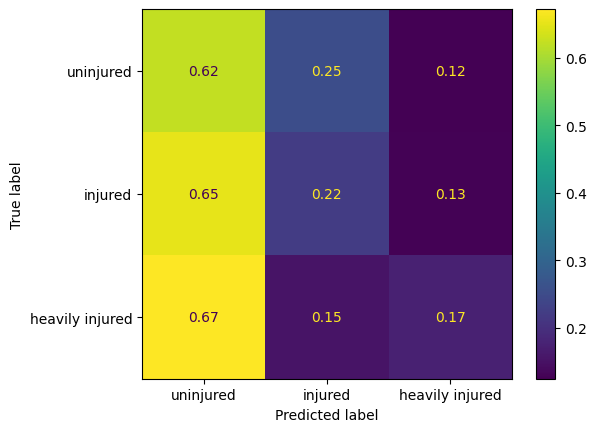

In [ ]:
report(y_test, y_pred, 'LightGBM (Custom Ordinal Objective)')

### MLPClassifier

              precision    recall  f1-score   support

           0       0.86      0.76      0.80     51051
           1       0.64      0.58      0.61     39476
           2       0.47      0.72      0.57     17440

    accuracy                           0.69    107967
   macro avg       0.65      0.69      0.66    107967
weighted avg       0.72      0.69      0.69    107967



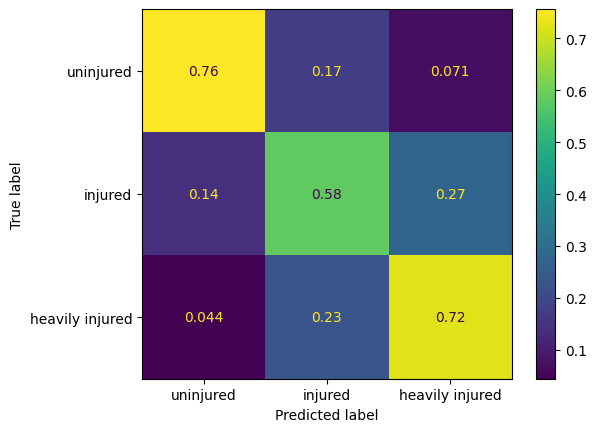

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import PolynomialFeatures

# mlp_transformer = ColumnTransformer([
#     ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
#     ('num', StandardScaler(), num_cols)
# ], remainder='drop')

mlp_transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('num_poly', Pipeline(steps=[
        ('poly', PolynomialFeatures(degree=2, include_bias=False, interaction_only=True)),
        ('scale', StandardScaler())
    ]), num_cols),
], remainder='drop')

X_tr_mlp = mlp_transformer.fit_transform(X_train)
X_te_mlp = mlp_transformer.transform(X_test)

# class_counts = np.bincount(y_train.to_numpy())
# print(class_counts)
# class_weights = class_counts.sum() / (len(class_counts) * class_counts)
# print(class_weights)
# sample_weight = class_weights[y_train.to_numpy()]
# print(sample_weight)

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train) 
sample_weight = class_weights[y_train.to_numpy()]

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate='adaptive',
    learning_rate_init=1e-3,
    batch_size=512,
    max_iter=8192,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=30,
)

mlp.fit(X_tr_mlp, y_train, sample_weight=sample_weight)

y_pred = mlp.predict(X_te_mlp)

print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()

Best thresholds (focus on 1 & 2): t1=0.560, t2=0.660, val F1_1_2=0.6076
              precision    recall  f1-score   support

           0       0.89      0.70      0.79     51051
           1       0.59      0.72      0.65     39476
           2       0.52      0.59      0.55     17440

    accuracy                           0.69    107967
   macro avg       0.67      0.67      0.66    107967
weighted avg       0.72      0.69      0.70    107967



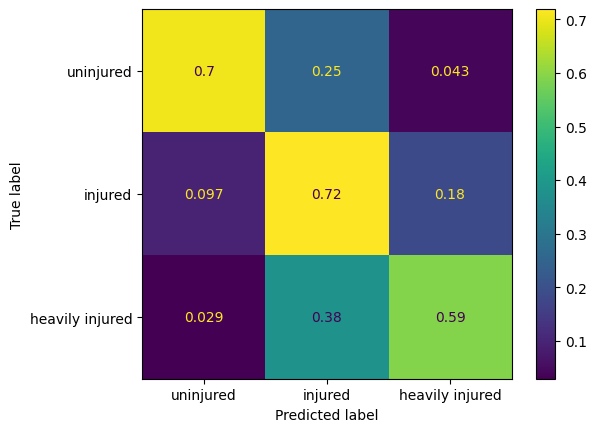

In [ ]:
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# ---------- Preprocessing: dense features for MLP ----------
# OneHotEncoder -> dense (MLP needs dense); Standardize numerics
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sklearn >=1.2
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)         # older sklearn

preprocess = ColumnTransformer(
    transformers=[
        ('cat', ohe, cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop'
)

# Fit/transform
X_tr_all = preprocess.fit_transform(X_train)
X_te = preprocess.transform(X_test)

# Validation split for threshold tuning
X_tr, X_va, y_tr, y_va = train_test_split(
    X_tr_all, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# ---------- Ordinal setup: cumulative labels ----------
# K = 3 -> heads for k=1,2 predicting P(y >= k)
K = int(np.max(y_tr)) + 1
assert K == 3, "This code expects labels {0,1,2}."
Km1 = K - 1

def to_cumulative_targets(y):
    return np.column_stack([(y >= k).astype(int) for k in range(1, K)])

Y_tr = to_cumulative_targets(y_tr)
Y_va = to_cumulative_targets(y_va)

# ---------- Per-sample weights (class balance + focus on classes 1 & 2) ----------
cls = np.array([0, 1, 2])
base_cw = compute_class_weight(class_weight='balanced', classes=cls, y=y_tr)  # inversely proportional to freq
# Extra emphasis on the problematic classes; tune these multipliers if needed
focus = np.array([1.0, 1.35, 1.6])
class_weight_vec = base_cw * focus
sample_weight_tr = class_weight_vec[y_tr]

# ---------- MLP (multi-label: two sigmoid heads) ----------
# Good starting point; increase width/depth if you have more data / features
mlp = MLPClassifier(
    hidden_layer_sizes=(512, 512, 512, 256, 3),
    activation='relu',
    solver='adam',
    alpha=1e-4,                    # L2
    batch_size=8192,
    learning_rate='adaptive',
    learning_rate_init=1e-3,
    max_iter=10000,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=20,
    shuffle=True,
    random_state=42,
    verbose=False
)

# Fit on cumulative targets
mlp.fit(X_tr, Y_tr, sample_weight=sample_weight_tr)

# ---------- Helper functions for cumulative probs -> class predictions ----------
def _enforce_cumulative(p_cum):
    # Ensure P(y>=1) >= P(y>=2)
    return np.minimum.accumulate(p_cum, axis=1)

def _cum_to_class_probs(p_cum, eps=1e-12):
    # p_cum shape (n, 2) for K=3
    p_cum = _enforce_cumulative(p_cum)
    p0 = 1.0 - p_cum[:, 0]
    p1 = p_cum[:, 0] - p_cum[:, 1]
    p2 = p_cum[:, 1]
    probs = np.column_stack([p0, p1, p2])
    probs = np.clip(probs, eps, 1.0)
    probs /= probs.sum(axis=1, keepdims=True)
    return probs

def predict_cum_proba(model, X):
    """
    For multilabel MLPClassifier, predict_proba returns a list of length n_outputs,
    each element of shape (n_samples, 2). We take column 1 (prob of label==1) per head.
    """
    proba = model.predict_proba(X)
    if isinstance(proba, list):
        # Two heads: k=1,2. Each p_k is (n, 2). Take prob of class '1'.
        p = np.column_stack([p_k[:, 1] for p_k in proba])  # (n, 2)
    else:
        # Safety fallback; should not occur in multi-label mode
        if proba.ndim == 2 and proba.shape[1] == Km1:
            p = proba
        else:
            raise RuntimeError("Unexpected predict_proba output shape.")
    return _enforce_cumulative(p)

def predict_with_thresholds(p_cum, t1=0.5, t2=0.5):
    """
    Decision rule using cumulative thresholds:
      if P(y>=2) >= t2 -> class 2
      elif P(y>=1) >= t1 -> class 1
      else -> class 0
    """
    return np.where(p_cum[:, 1] >= t2, 2,
                    np.where(p_cum[:, 0] >= t1, 1, 0))

# ---------- Tune thresholds to maximize F1 on classes 1 & 2 ----------
p_va_cum = predict_cum_proba(mlp, X_va)

def f1_for_cls(y_true, y_pred, c):
    # Binary F1 for "class c vs rest"
    return f1_score((y_true == c).astype(int), (y_pred == c).astype(int), zero_division=0)

best = {"score": -1, "t1": 0.5, "t2": 0.5}
for t1 in np.linspace(0.2, 0.8, 31):
    for t2 in np.linspace(0.2, 0.8, 31):
        y_hat = predict_with_thresholds(p_va_cum, t1=t1, t2=t2)
        f1_1 = f1_for_cls(y_va, y_hat, 1)
        f1_2 = f1_for_cls(y_va, y_hat, 2)
        score = 0.5 * (f1_1 + f1_2)  # focus specifically on classes 1 and 2
        if score > best["score"]:
            best = {"score": score, "t1": float(t1), "t2": float(t2)}

print(f"Best thresholds (focus on 1 & 2): t1={best['t1']:.3f}, t2={best['t2']:.3f}, "
      f"val F1_1_2={(best['score']):.4f}")

# ---------- Evaluate on the test set ----------
p_te_cum = predict_cum_proba(mlp, X_te)
y_pred = predict_with_thresholds(p_te_cum, t1=best["t1"], t2=best["t2"])

report(y_test, y_pred)


In [ ]:
import numpy as np
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Assume you already have:
# - hgb: trained HistGradientBoostingClassifier
# - lgb_ord: your ordinal LightGBM trained on cumulative labels
# - preprocessors done: X_tr, X_va, y_tr, y_va, X_te, y_te
# - functions: enforce_cumulative(), cum_to_class_probs()

# 1) Calibrate HGB (probabilities) on validation
hgb_cal = CalibratedClassifierCV(hgb, method='sigmoid', cv='prefit')
hgb_cal.fit(X_va, y_va)

# 2) Build a thin wrapper that returns class-probs from your ordinal model
def ord_class_proba(model, X):
    raw = model.predict(X, raw_score=True)
    # reshape robustly
    Km1 = 2
    if raw.ndim == 1:
        raw = raw.reshape(Km1, -1).T
    # cumulative probs via sigmoid
    from scipy.special import expit
    p_cum = expit(raw)
    # monotonic + conversion
    p_cum = np.minimum.accumulate(p_cum, axis=1)
    p0 = 1 - p_cum[:,0]
    p1 = p_cum[:,0] - p_cum[:,1]
    p2 = p_cum[:,1]
    probs = np.column_stack([p0,p1,p2])
    probs = np.clip(probs, 1e-12, 1.0)
    probs /= probs.sum(axis=1, keepdims=True)
    return probs

# Calibrate ordinal probs per class (one-vs-rest) using logistic calibration
# (we’ll calibrate each class’s score vs rest with a simple logistic on the prob)
from sklearn.linear_model import LogisticRegression

def calibrate_ordinal_probs(X_cal, y_cal):
    P = ord_class_proba(lgb_ord, X_cal)
    C = []
    for k in [0,1,2]:
        lr = LogisticRegression(max_iter=1000, class_weight='balanced')
        lr.fit(P, (y_cal==k).astype(int))  # simple meta-calibration on probs
        C.append(lr)
    return C

ord_cal = calibrate_ordinal_probs(X_va, y_va)

def ord_calibrated_proba(X):
    P = ord_class_proba(lgb_ord, X)
    Pcal = []
    for k, lr in enumerate(ord_cal):
        # predict calibrated probability of "class k" vs rest
        Pcal.append(lr.predict_proba(P)[:,1])
    Pcal = np.column_stack(Pcal)
    Pcal = np.clip(Pcal, 1e-12, 1.0)
    Pcal /= Pcal.sum(axis=1, keepdims=True)
    return Pcal

# 3) Tune ensemble weight + hierarchical thresholds to maximize F1(1)&F1(2)
def predict_hier(probs, t1, t2):
    # Convert class probs to cumulative heads for the rule
    p_cum = np.column_stack([1 - probs[:,0], 1 - probs[:,0] - probs[:,1]])  # [P>=1, P>=2]
    return np.where(p_cum[:,1] >= t2, 2,
                    np.where(p_cum[:,0] >= t1, 1, 0))

def tune_all(Xv, yv):
    Ph = hgb_cal.predict_proba(Xv)
    Po = ord_calibrated_proba(Xv)
    best = {"score": -1}
    grid_w = np.linspace(0.2, 0.8, 13)      # weight for HGB; ord weight = 1-w
    grid_t = np.linspace(0.2, 0.8, 31)
    for w in grid_w:
        P = w*Ph + (1-w)*Po
        for t1 in grid_t:
            for t2 in grid_t:
                yhat = predict_hier(P, t1, t2)
                f1_1 = f1_score(yv==1, yhat==1, zero_division=0)
                f1_2 = f1_score(yv==2, yhat==2, zero_division=0)
                score = 0.5*(f1_1 + f1_2)
                if score > best["score"]:
                    best = {"score":score, "w":w, "t1":t1, "t2":t2}
    return best

best = tune_all(X_va, y_va)
print("Best (focus 1&2):", best)

# 4) Final evaluation on test
Ph_te = hgb_cal.predict_proba(X_te)
Po_te = ord_calibrated_proba(X_te)
P_te = best["w"]*Ph_te + (1-best["w"])*Po_te
y_pred = predict_hier(P_te, best["t1"], best["t2"])

print(classification_report(y_test, y_pred, digits=3))
print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))


In [19]:
X_tr_1_2 = X_train[(y_train == 1) | (y_train == 2)]
y_tr_1_2 = y_train[(y_train == 1) | (y_train == 2)]


X_te_1_2 = X_test[(y_test == 1) | (y_test == 2)]
y_te_1_2 = y_test[(y_test == 1) | (y_test == 2)]

In [ ]:
from catboost import CatBoostClassifier

# categorical feature indices
cat_idx = [X_train.columns.get_loc(c) for c in cat_cols]

catBoost = CatBoostClassifier(
    loss_function='Logloss',
    eval_metric='F1',
    task_type='GPU',
    devices='0',
    auto_class_weights='Balanced',
    cat_features=cat_idx,
    iterations=10000
)

catBoost.fit(X_tr_1_2, y_tr_1_2)

y_pred = catBoost.predict(X_te_1_2)

Learning rate set to 0.003182
0:	learn: 0.6685571	total: 93.8ms	remaining: 15m 37s
1:	learn: 0.6757536	total: 188ms	remaining: 15m 38s
2:	learn: 0.6809508	total: 276ms	remaining: 15m 18s
3:	learn: 0.6779724	total: 360ms	remaining: 14m 59s
4:	learn: 0.6782783	total: 442ms	remaining: 14m 43s
5:	learn: 0.6819473	total: 526ms	remaining: 14m 36s
6:	learn: 0.6814231	total: 610ms	remaining: 14m 30s
7:	learn: 0.6818169	total: 692ms	remaining: 14m 24s
8:	learn: 0.6812775	total: 784ms	remaining: 14m 30s
9:	learn: 0.6798817	total: 869ms	remaining: 14m 28s
10:	learn: 0.6797628	total: 952ms	remaining: 14m 24s
11:	learn: 0.6827959	total: 1.03s	remaining: 14m 19s
12:	learn: 0.6827967	total: 1.12s	remaining: 14m 17s
13:	learn: 0.6826375	total: 1.2s	remaining: 14m 16s
14:	learn: 0.6815836	total: 1.28s	remaining: 14m 15s
15:	learn: 0.6814130	total: 1.37s	remaining: 14m 14s
16:	learn: 0.6813942	total: 1.46s	remaining: 14m 15s
17:	learn: 0.6804007	total: 1.54s	remaining: 14m 14s
18:	learn: 0.6795947	total

              precision    recall  f1-score   support

           1       0.85      0.74      0.79     39476
           2       0.55      0.71      0.62     17440

    accuracy                           0.73     56916
   macro avg       0.70      0.73      0.71     56916
weighted avg       0.76      0.73      0.74     56916



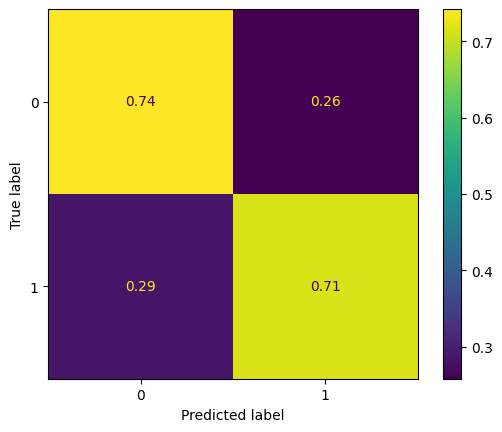

In [ ]:
print(classification_report(y_te_1_2, y_pred))
ConfusionMatrixDisplay(
    confusion_matrix(y_te_1_2, y_pred, normalize='true')
).plot()


In [20]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.ensemble import HistGradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

transformer = ColumnTransformer([
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
    ('num', 'passthrough', num_cols)
], remainder='drop')

X_tr = transformer.fit_transform(X_tr_1_2)
X_te = transformer.transform(X_te_1_2)

In [ ]:
# Categorical cols are first block -> indices 0 .. len(cat_cols)-1
cat_idx = list(range(len(cat_cols)))

sw = compute_sample_weight(class_weight='balanced', y=y_tr_1_2)

gb = HistGradientBoostingClassifier(
    categorical_features=cat_idx,
    learning_rate=0.05,
    max_depth=6,
    max_iter=700,
    min_samples_leaf=60,
    l2_regularization=1.0
)

gb.fit(X_tr, y_tr_1_2, sample_weight=sw)

NameError: name 'X_tr_1_2' is not defined

In [ ]:
y_pred_gb = gb.predict(X_te)

print(classification_report(y_te_1_2, y_pred_gb))
ConfusionMatrixDisplay(
    confusion_matrix(y_te_1_2, y_pred_gb, normalize='true')
).plot()

In [36]:
rf = BalancedRandomForestClassifier(n_jobs=-1, n_estimators=5000, sampling_strategy='not minority', max_depth=5)
rf.fit(X_tr, y_tr_1_2)

KeyboardInterrupt: 

In [ ]:
y_pred_rf = rf.predict(X_te)

print(classification_report(y_te_1_2, y_pred_rf))
ConfusionMatrixDisplay(
    confusion_matrix(y_te_1_2, y_pred_rf, normalize='true')
).plot()

In [25]:
mlp_transformer = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), cat_cols),
    ('scale', StandardScaler(), num_cols)
], remainder='drop')

sw = compute_sample_weight(class_weight='balanced', y=y_tr_1_2)

mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64),
    activation='relu',
    solver='adam',
    alpha=1e-4,
    learning_rate='adaptive',
    learning_rate_init=1e-3,
    batch_size=512,
    max_iter=8192,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=30,
)

pipeline = Pipeline([
    ('pre', mlp_transformer),
    ('mlp', mlp)
])

pipeline.fit(X_tr_1_2, y_tr_1_2, mlp__sample_weight=sw)

,steps,"[('pre', ...), ('mlp', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('scale', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


              precision    recall  f1-score   support

           1       0.86      0.71      0.78     39476
           2       0.53      0.74      0.62     17440

    accuracy                           0.72     56916
   macro avg       0.70      0.73      0.70     56916
weighted avg       0.76      0.72      0.73     56916



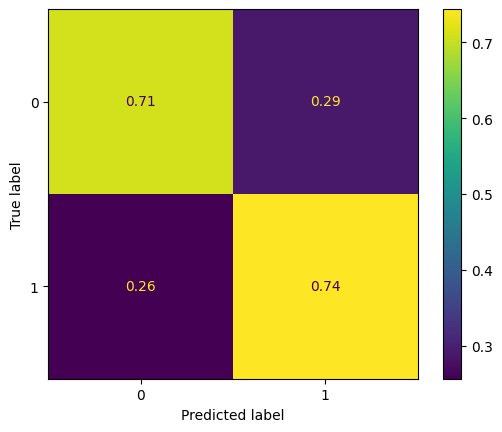

In [31]:
y_pred_mlp = pipeline.predict(X_te_1_2)

print(classification_report(y_te_1_2, y_pred_mlp))
ConfusionMatrixDisplay(
    confusion_matrix(y_te_1_2, y_pred_mlp, normalize='true')
).plot()

c:\Users\David\Desktop\PythonKurs\Data_Mining_I\Project\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Stacked ensemble (sklearn) macro F1: 0.6727824275272903
              precision    recall  f1-score   support

           0       0.87      0.76      0.81     51051
           1       0.63      0.62      0.63     39476
           2       0.49      0.70      0.58     17440

    accuracy                           0.70    107967
   macro avg       0.67      0.69      0.67    107967
weighted avg       0.72      0.70      0.71    107967



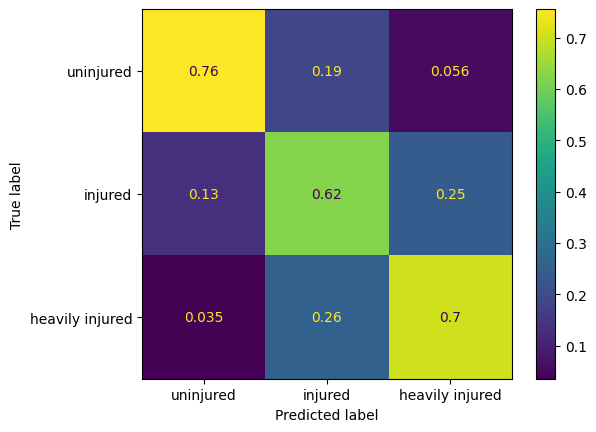

In [16]:
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight

class SampleWeightPipeline(Pipeline):
    def fit(self, X, y=None, sample_weight=None, **fit_params):
        if sample_weight is not None:
            fit_params = fit_params.copy()
            fit_params[self.steps[-1][0] + '__sample_weight'] = sample_weight
        return super().fit(X, y, **fit_params)

hgb_pipe = SampleWeightPipeline([
    ('prep', ColumnTransformer([
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
        ('num', 'passthrough', num_cols)
    ], remainder='drop')),
    ('clf', HistGradientBoostingClassifier(
        categorical_features=list(range(len(cat_cols))),
        learning_rate=0.05,
        max_iter=700,
        max_depth=6,
        min_samples_leaf=60,
        l2_regularization=10.0,
        random_state=42
    ))
])

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

mlp_pipe = SampleWeightPipeline([
    ('prep', ColumnTransformer([
        ('cat', ohe, cat_cols),
        ('num', StandardScaler(), num_cols)
    ], remainder='drop')),
    ('clf', MLPClassifier(
        hidden_layer_sizes=(256, 128, 64),
        activation='relu',
        solver='adam',
        alpha=1e-4,
        batch_size=512,
        learning_rate='adaptive',
        learning_rate_init=1e-3,
        max_iter=400,
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=20,
        random_state=42
    ))
])

cat_est = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='TotalF1',
    bootstrap_type='Bernoulli',
    devices='0',
    task_type='GPU',
    depth=8,
    learning_rate=0.08,
    iterations=800,
    subsample=0.7,
    random_seed=42,
    verbose=0,
    cat_features=[X_train.columns.get_loc(c) for c in X_train.columns if c not in num_cols]
)

stack = StackingClassifier(
    estimators=[
        ('hgb', hgb_pipe),
        ('mlp', mlp_pipe),
        ('cat', cat_est)
    ],
    final_estimator=LogisticRegression(
        max_iter=2000,
        multi_class='multinomial',
        class_weight='balanced',
        solver='lbfgs',
        random_state=42
    ),
    stack_method='predict_proba',
    passthrough=False,
    n_jobs=1
)

sw = compute_sample_weight(class_weight='balanced', y=y_train)
stack.fit(X_train, y_train, sample_weight=sw)

y_pred = stack.predict(X_test)

print("Stacked ensemble (sklearn) macro F1:", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()
plt.show()

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best params: {'rbf__n_components': 1600, 'rbf__gamma': np.float64(0.006158482110660267), 'clf__C': np.float64(0.019539304046896112)}
Best CV macro F1: 0.5945553730285648
SVM (Nyström RBF) macro F1: 0.5961850305560547
              precision    recall  f1-score   support

           0       0.80      0.73      0.76     51051
           1       0.58      0.49      0.53     39476
           2       0.40      0.64      0.49     17440

    accuracy                           0.63    107967
   macro avg       0.59      0.62      0.60    107967
weighted avg       0.65      0.63      0.63    107967



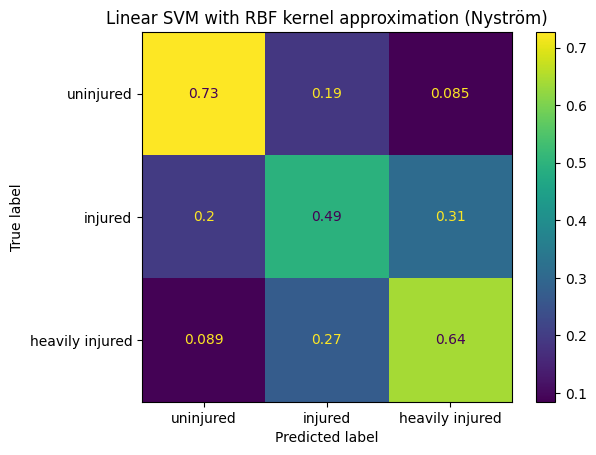

In [13]:
# Way too slow for training, if possible, only on a limited subset of the training data.

# SVM with RBF kernel approximation (Nyström) + class weighting
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.kernel_approximation import Nystroem
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.class_weight import compute_sample_weight

# Preprocess: OHE for categoricals (dense), scale numerics
try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

preprocess = ColumnTransformer(
    transformers=[
        ('cat', ohe, cat_cols),
        ('num', StandardScaler(), num_cols)
    ],
    remainder='drop'
)

# Pipeline: preprocess -> Nyström RBF mapping -> scale -> linear SVM
svm_rbf_pipe = ImbPipeline(steps=[
    ('under_sample', RandomUnderSampler(sampling_strategy={0:1000, 1:1000, 2:1000}, random_state=42)),
    ('prep', preprocess),
    ('rbf', Nystroem(kernel='rbf', gamma=0.05, random_state=42)),
    ('scale', StandardScaler()),  # center/scale mapped features
    ('clf', LinearSVC(C=1.0, class_weight='balanced', random_state=42))
])

# Lightweight hyperparameter search
param_dist = {
    'rbf__gamma': np.logspace(-3, 0, 20),
    'rbf__n_components': [800, 1200, 1600, 2200],
    'clf__C': np.logspace(-2, 1.2, 12)
}

search = RandomizedSearchCV(
    estimator=svm_rbf_pipe,
    param_distributions=param_dist,
    n_iter=5,
    scoring='f1_macro',
    cv=3,
    random_state=42,
    n_jobs=2,
    verbose=3,
)

search.fit(X_train, y_train)

print("Best params:", search.best_params_)
print("Best CV macro F1:", search.best_score_)

best_svm = search.best_estimator_
y_pred = best_svm.predict(X_test)

print("SVM (Nyström RBF) macro F1:", f1_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay(
    confusion_matrix(y_test, y_pred, normalize='true'),
    display_labels=['uninjured', 'injured', 'heavily injured']
).plot()
plt.title("Linear SVM with RBF kernel approximation (Nyström)")
plt.show()

[VALIDATION] best penalized score=0.4503 with t1=0.60, t2=0.66, delta=0.00

=== TEST RESULTS ===
Macro-F1: 0.6602 | Penalized (w12=2.0): 0.4422
Thresholds: t1(injury)=0.60, t2(heavy)=0.66, margin delta=0.00

              precision    recall  f1-score   support

           0      0.776     0.860     0.816     51051
           1      0.652     0.603     0.627     39476
           2      0.584     0.498     0.538     17440

    accuracy                          0.708    107967
   macro avg      0.671     0.654     0.660    107967
weighted avg      0.700     0.708     0.702    107967



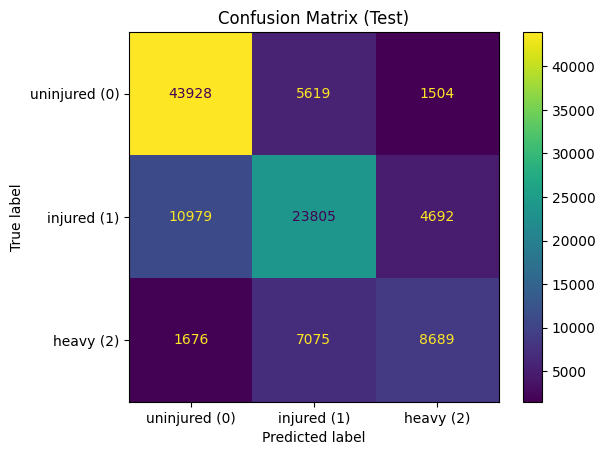

In [37]:
# 🔧 One-cell hierarchical pipeline with: calibration (both stages) + validation-based threshold & margin tuning +
#     stage-2 conditional inference + cost-sensitive (1↔2) penalty. Ready to run with:
#     X_train, y_train, X_test, y_test, cat_cols, num_cols already defined.

import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import (
    classification_report, confusion_matrix, f1_score, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# -----------------------
# Config (adjust if needed)
# -----------------------
RANDOM_STATE = 42
# Stage-1 (0 vs 1+2) hyperparams (taken from your best run)
ST1_PARAMS = dict(
    learning_rate=0.05352681822847106,
    max_depth=6,
    max_iter=700,
    min_samples_leaf=63,
    l2_regularization=27.825594022071257,
    random_state=RANDOM_STATE
)
# Stage-2 (1 vs 2) hyperparams (slightly freer boundary: smaller leaf, lighter regularization)
ST2_PARAMS = dict(
    learning_rate=0.05352681822847106,
    max_depth=6,
    max_iter=700,
    min_samples_leaf=40,
    l2_regularization=0.1,
    random_state=RANDOM_STATE + 1
)
# Threshold/margin search grids (fast defaults; widen if you like)
T1_GRID = np.arange(0.30, 0.85, 0.02)   # injury threshold
T2_GRID = np.arange(0.30, 0.85, 0.02)   # heavy threshold
DELTA_GRID = (0.00, 0.01, 0.02, 0.05, 0.08)  # p2 - p1 margin
W12_PENALTY = 2.0  # weight for 1<->2 confusion penalty in validation score

# -----------------------
# Helpers
# -----------------------
def make_transformer(cat_cols, num_cols):
    return ColumnTransformer(
        transformers=[
            ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_cols),
            ('num', 'passthrough', num_cols),
        ],
        remainder='drop'
    )

def fit_calibrated_stages(X_df, y, transformer, cat_cols):
    """Fit Stage-1 (0 vs 1+2) and Stage-2 (1 vs 2) on transformed arrays, then isotonic calibration."""
    X_full = transformer.fit_transform(X_df)  # fit on provided data
    cat_idx = list(range(len(cat_cols)))

    # Stage-1 labels & weights
    y1 = (y >= 1).astype(int)
    sw1 = compute_sample_weight(class_weight='balanced', y=y1)

    st1 = HistGradientBoostingClassifier(categorical_features=cat_idx, **ST1_PARAMS)
    st1.fit(X_full, y1, sample_weight=sw1)
    cal1 = CalibratedClassifierCV(st1, method="isotonic", cv=3)
    cal1.fit(X_full, y1, sample_weight=sw1)

    # Stage-2 data/labels & weights (only injured)
    inj_mask = (y >= 1).astype(bool)
    X_inj = X_full[inj_mask]
    y2 = (y[inj_mask] == 2).astype(int)
    sw2 = compute_sample_weight(class_weight='balanced', y=y2)

    st2 = HistGradientBoostingClassifier(categorical_features=cat_idx, **ST2_PARAMS)
    st2.fit(X_inj, y2, sample_weight=sw2)
    cal2 = CalibratedClassifierCV(st2, method="isotonic", cv=3)
    cal2.fit(X_inj, y2, sample_weight=sw2)

    return cal1, cal2, transformer  # calibrated models + fitted transformer

def predict_probs_conditional(cal1, cal2, X_df, transformer, t1=None):
    """Get p_inj and conditional p_heavy; stage-2 only evaluated where p_inj >= t1 (if provided)."""
    X_full = transformer.transform(X_df)
    p_inj = cal1.predict_proba(X_full)[:, 1]

    if t1 is None:  # unconditional (evaluate stage-2 everywhere, though slightly distribution-shifted)
        p_heavy = cal2.predict_proba(X_full)[:, 1]
        return p_inj, p_heavy

    # conditional inference: call stage-2 only where likely injured
    p_heavy = np.zeros_like(p_inj)
    inj_mask = p_inj >= t1
    if inj_mask.any():
        p_heavy[inj_mask] = cal2.predict_proba(X_full[inj_mask])[:, 1]
    return p_inj, p_heavy

def predict_with_thresholds_and_margin(p_inj, p_heavy, t1, t2, delta):
    """Hierarchical prediction with injury/heavy thresholds and a p2-p1 margin rule."""
    p2 = p_inj * p_heavy
    p1 = np.clip(p_inj - p2, 0, 1)
    out = np.zeros_like(p_inj, dtype=int)
    inj_mask = p_inj >= t1
    out[inj_mask] = 1
    heavy_mask = inj_mask & (p_heavy >= t2) & ((p2 - p1) >= delta)
    out[heavy_mask] = 2
    return out

def penalized_macro_f1(y_true, y_pred, w12=2.0):
    base = f1_score(y_true, y_pred, average='macro')
    cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
    penalty = w12 * (cm[1,2] + cm[2,1]) / max(1, cm.sum())
    return base - penalty

# -----------------------
# 1) Split a validation set from TRAIN for tuning (avoid test leakage)
# -----------------------
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
tr_idx, va_idx = next(sss.split(X_train, y_train))
X_tr, y_tr = X_train.iloc[tr_idx], y_train.iloc[tr_idx]
X_va, y_va = X_train.iloc[va_idx], y_train.iloc[va_idx]

# -----------------------
# 2) Fit on the TRAIN-FOLD and tune thresholds/margin on VALIDATION
# -----------------------
# Fresh transformer fit on the train-fold (avoid leakage)
tf_val = make_transformer(cat_cols, num_cols)
cal1_val, cal2_val, tf_val = fit_calibrated_stages(X_tr, y_tr.values, tf_val, cat_cols)

# Get probabilities on validation (use unconditional for faster sweep first)
p_inj_va, p_heavy_va = predict_probs_conditional(cal1_val, cal2_val, X_va, tf_val, t1=None)

best = (-np.inf, None, None, None)  # (score, t1, t2, delta)
for t1 in T1_GRID:
    # switch to conditional p_heavy using current t1 (more realistic)
    p_inj_va_t, p_heavy_va_t = predict_probs_conditional(cal1_val, cal2_val, X_va, tf_val, t1=t1)
    for t2 in T2_GRID:
        for d in DELTA_GRID:
            y_hat = predict_with_thresholds_and_margin(p_inj_va_t, p_heavy_va_t, t1, t2, d)
            s = penalized_macro_f1(y_va, y_hat, w12=W12_PENALTY)
            if s > best[0]:
                best = (s, t1, t2, d)

best_score_val, BEST_T1, BEST_T2, BEST_DELTA = best
print(f"[VALIDATION] best penalized score={best_score_val:.4f} with t1={BEST_T1:.2f}, t2={BEST_T2:.2f}, delta={BEST_DELTA:.2f}")

# -----------------------
# 3) Refit calibrated stages on FULL TRAIN using the tuned thresholds/margin
# -----------------------
tf_full = make_transformer(cat_cols, num_cols)
cal1_full, cal2_full, tf_full = fit_calibrated_stages(X_train, y_train.values, tf_full, cat_cols)

# -----------------------
# 4) Final evaluation on TEST (conditional stage-2 inference)
# -----------------------
p_inj_te, p_heavy_te = predict_probs_conditional(cal1_full, cal2_full, X_test, tf_full, t1=BEST_T1)
y_pred_test = predict_with_thresholds_and_margin(p_inj_te, p_heavy_te, BEST_T1, BEST_T2, BEST_DELTA)

macro_f1 = f1_score(y_test, y_pred_test, average='macro')
pen_score = penalized_macro_f1(y_test, y_pred_test, w12=W12_PENALTY)

print("\n=== TEST RESULTS ===")
print(f"Macro-F1: {macro_f1:.4f} | Penalized (w12={W12_PENALTY}): {pen_score:.4f}")
print(f"Thresholds: t1(injury)={BEST_T1:.2f}, t2(heavy)={BEST_T2:.2f}, margin delta={BEST_DELTA:.2f}\n")
print(classification_report(y_test, y_pred_test, digits=3))

cm = confusion_matrix(y_test, y_pred_test, labels=[0,1,2])
disp = ConfusionMatrixDisplay(cm, display_labels=['uninjured (0)','injured (1)','heavy (2)'])
disp.plot(values_format='d')
plt.title("Confusion Matrix (Test)")
plt.show()
